In [11]:
#%%=========================================================
# Intialize
# Had to put __future__ before other imports
from __future__ import division, print_function
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20
import os
import requests
import pandas as pd
from cStringIO import StringIO
import pickle

# The following commands are for use in the notebook environment
# Comment them out if this code is to be run in a python or ipython shell
%matplotlib inline
%config InlineBackend.figure_format = "retina"



In [12]:
#%%=========================================================
# This function downloads and caches a dataset from the exoplanet archive
# into a pandas frame
def get_catalog(name, basepath="data"):
    fn = os.path.join(basepath, "{0}.h5".format(name))
    if os.path.exists(fn):
        return pd.read_hdf(fn, name)
    if not os.path.exists(basepath):
        os.makedirs(basepath)
    print("Downloading {0}...".format(name))
    url = ("http://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/"
           "nph-nstedAPI?table={0}&select=*").format(name)
    r = requests.get(url)
    if r.status_code != requests.codes.ok:
        r.raise_for_status()
    fh = StringIO(r.content)
    df = pd.read_csv(fh)
    df.to_hdf(fn, name, format="t")
    return df
    


In [13]:
periodInsolationSwitch = 'P' #raw_input("Period or Insolation: P or I? -- ")
catalogSwitch = '1' # raw_input("Catalog 9.1 or 9.2: 1 or 2? -- ")
stellarTypeSwitch = raw_input("Stellar type: GK, A, F, G, K, or M? -- ")

Stellar type: GK, A, F, G, K, or M? -- G


In [14]:
#%%=========================================================
# Get the stellar catalog and make selection cuts   
import numpy as np

# Choose desired stellar catalog
if(catalogSwitch == "1"):
    #!!!!! Q1-Q16 (9.1 pipeline)
    stlr = get_catalog("q1_q16_stellar")
elif(catalogSwitch == "2"):
    #!!!!! Q1-Q17 DR 24 (9.2 pipeline)
    stlr = get_catalog("q1_q17_dr24_stellar")


# Select stellar type
if(stellarTypeSwitch == 'A'):
    # !!!!! Select A dwarfs.
    m = (7300 <= stlr.teff) & (stlr.teff <= 10000)

elif(stellarTypeSwitch == 'F'):
    # !!!!! Select F dwarfs.
    m = (6000 <= stlr.teff) & (stlr.teff <= 7300)

elif(stellarTypeSwitch == 'G'):
    # !!!!! Select G dwarfs.
    m = (5300 <= stlr.teff) & (stlr.teff <= 6000)

elif(stellarTypeSwitch == 'K'):
    # !!!!! Select K dwarfs.
    m = (3900 <= stlr.teff) & (stlr.teff <= 5300)

elif(stellarTypeSwitch == 'M'):
    # !!!!! Select M dwarfs.
    m = (2400 <= stlr.teff) & (stlr.teff <= 3900)

elif(stellarTypeSwitch == 'GK'):
    # !!!!! Select GK dwarfs used i DFM original notebook.
    m = (4200 <= stlr.teff) & (stlr.teff <= 6100)


# stellar radius cut
# m &= stlr.radius <= 1.15

# logg cut
m &= stlr.logg > 4.0

# Only include stars with sufficient data coverage:

# Minimum dataspan of 2 years
m &= stlr.dataspan > 365.25*2.

# Minimum dutycycle of 1/2
#m &= stlr.dutycycle > 0.50
#### 0.6 in DFM original notebook:
m &= stlr.dutycycle > 0.60


# Minimum data coverage of 2 years
# comment out to compare to DFM origina notebook
#m &= stlr.dutycycle*stlr.dataspan > 365.25*2.

# maximum rms cdpp at 7.5 hour pulse (uncomment to compare to DFM original notebook)
m &= stlr.rrmscdpp07p5 <= 1000.

# Only select stars with mass estimates.
m &= np.isfinite(stlr.mass)

# put selected data into pandas data frame
base_stlr = pd.DataFrame(stlr)
stlr = pd.DataFrame(stlr[m])

print("Selected {0} targets after cuts".format(len(stlr)))


Selected 59792 targets after cuts


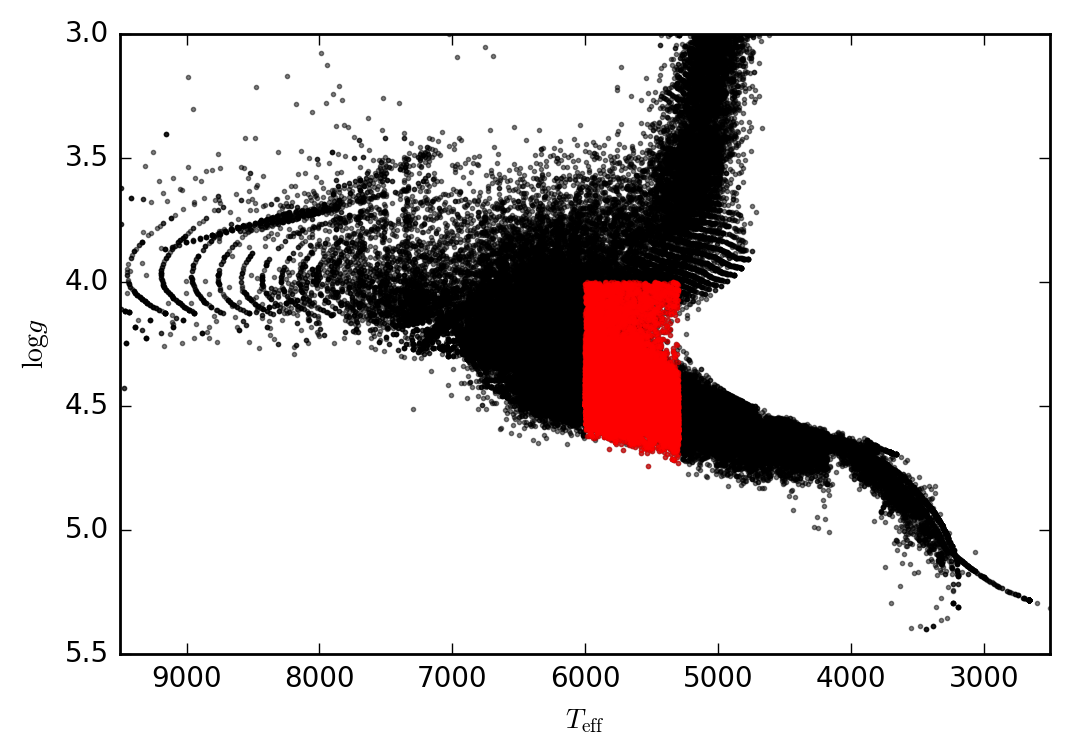

In [15]:
#%%=========================================================
# Plot an HR diagram of the selected targets
import matplotlib.pyplot as pl

pl.plot(base_stlr.teff, base_stlr.logg, ".k", ms=3, alpha=0.5)
pl.plot(stlr.teff, stlr.logg, ".r", ms=3, alpha=0.5)
pl.xlim(9500, 2500)
pl.ylim(5.5, 3)
pl.ylabel("$\log g$");
pl.xlabel("$T_\mathrm{eff}$");


In [16]:
#%%=========================================================

# !!!!! Get the planet catalog and make selection cuts 

if(catalogSwitch == "1"):
    # !!!!! Q1-Q16 planet catalog (9.1 pipeline)
    kois = get_catalog("q1_q16_koi")

elif(catalogSwitch == "2"):
    # !!!!! Q1-Q17 DR24 (9.2 pipeline)
    kois = get_catalog("q1_q17_dr24_koi")


# Set insolation (or period) and planet radius ranges
# for power law fit
rp_rng = (0.75, 2.5)
if(periodInsolationSwitch=="I"):
    x_rng = (0.2, 20)
elif(periodInsolationSwitch=="P"):
    x_rng = (50, 300)

# Join on the stellar list.
kois = pd.merge(kois, stlr[["kepid"]], on="kepid", how="inner")

# Only select the KOIs in the relevant part of parameter space.
m = kois.koi_pdisposition == "CANDIDATE"
base_kois = pd.DataFrame(kois[m])

# Select planets based on either insolation or period
if(periodInsolationSwitch=='I'):
    # Select based on insolation range instead of period range
    m &= (x_rng[0] <= kois.koi_insol) & (kois.koi_insol <= x_rng[1])
elif(periodInsolationSwitch=='P'):
    # Select based on period range instead of insolation range
    m &= (x_rng[0] <= kois.koi_period) & (kois.koi_period <= x_rng[1])

# Select planet radius range
m &= np.isfinite(kois.koi_prad) & (rp_rng[0] <= kois.koi_prad) & (kois.koi_prad <= rp_rng[1])

# !!!!! Only include PCs with MES > 15 for 9.2 (Q1-Q17 Dr24)
# !!!!! For 9.1 (Q1-Q16) -- all max_mult_ev seem to be NaNs
if(catalogSwitch == "2"):
    m &= kois.koi_max_mult_ev > 15

# Panda data frame for selected kois
# Note that kois now contains only the selected planet candidates
kois = pd.DataFrame(kois[m])

#print("min insolation = {0} ".format(np.min((kois.koi_insol))))
#print("max insolation = {0} ".format(np.max((kois.koi_insol))))
#print(kois.koi_insol)


print("min period = {0} ".format(np.min(kois.koi_period)))
print("max period = {0} ".format(np.max(kois.koi_period)))
print("Selected {0} KOIs after cuts".format(len(kois)))


min period = 50.4473156 
max period = 289.864456 
Selected 93 KOIs after cuts


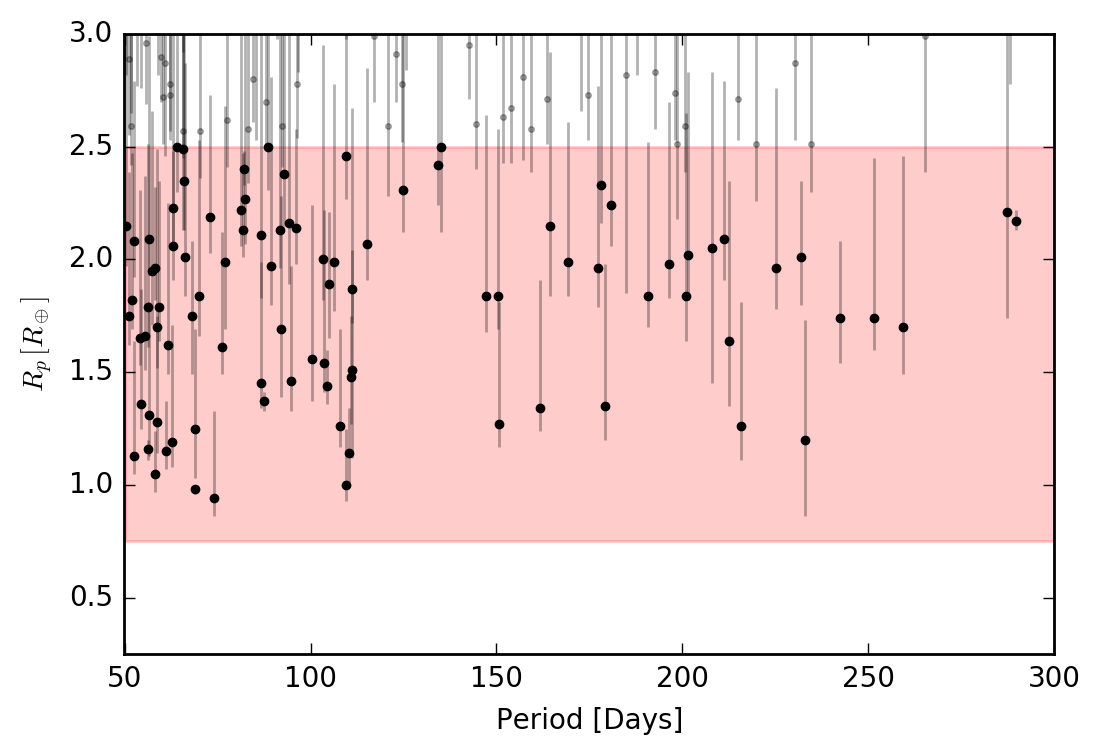

In [17]:
#%%=========================================================
# Plot the measurements with error bars, in insolation-radius parameter space
yerr = np.abs(np.array(base_kois[["koi_prad_err2", "koi_prad_err1"]])).T

if(periodInsolationSwitch=="I"):
    pl.xlabel("insolation [Earth units]")
    pl.errorbar(base_kois.koi_insol, base_kois.koi_prad, yerr=yerr, fmt=".k", ms=4,
            capsize=0, alpha=0.3)
    pl.plot(kois.koi_insol, kois.koi_prad, ".k", ms=6)
elif(periodInsolationSwitch=="P"):
    pl.xlabel("Period [Days]")
    pl.errorbar(base_kois.koi_period, base_kois.koi_prad, yerr=yerr, fmt=".k", ms=4,
            capsize=0, alpha=0.3)
    pl.plot(kois.koi_period, kois.koi_prad, ".k", ms=6)
pl.fill_between(x_rng, [rp_rng[1], rp_rng[1]], [rp_rng[0], rp_rng[0]], color="r", alpha=0.2)
pl.xlim(x_rng + 0.1 * np.array([-1, 1]))
pl.ylim(rp_rng + 0.5 * np.array([-1, 1]))


pl.ylabel("$R_p \, [R_\oplus]$");


In [18]:
#%%=========================================================
# Completeness model helper functions (radius and orbital period)

from scipy.stats import gamma

def get_duration(period, aor, e):
    """
    Equation (1) from Burke et al. This estimates the transit
    duration in the same units as the input period. There is a
    typo in the paper (24/4 = 6 != 4).
    
    :param period: the period in any units of your choosing
    :param aor:    the dimensionless semi-major axis (scaled
                   by the stellar radius)
    :param e:      the eccentricity of the orbit
    
    """
    return 0.25 * period * np.sqrt(1 - e**2) / aor

def get_a(period, mstar, Go4pi=2945.4625385377644/(4*np.pi*np.pi)):
    """
    Compute the semi-major axis of an orbit in Solar radii.
    
    :param period: the period in days
    :param mstar:  the stellar mass in Solar masses
    
    """
    return (Go4pi*period*period*mstar) ** (1./3)

def get_delta(k, catalogSwitch, c=1.0874, s=1.0187):
    """
    Estimate the approximate expected transit depth as a function
    of radius ratio. There might be a typo here. In the paper it
    uses c + s*k but in the public code, it is c - s*k:
    https://github.com/christopherburke/KeplerPORTs
    
    :param k: the dimensionless radius ratio between the planet and
              the star
    
    """
    delta_max = k*k * (c + s*k)
    
    if(catalogSwitch == '1'):
        maxDepth = 0.84*delta_max
        # !!!!! For Q1-Q16 (9.1 pipeline) DFM used a multiplier 0f 0.84 instead of 1.0 in the equation below
        # return 0.84*delta_max
    elif(catalogSwitch == '2'):
        # !!!!! for Q1-Q17 DR24 (9.2 pipeline), use a multiplier of 1
        #return 1.0* delta_max
        maxDepth = 1.0*delta_max
    
    return maxDepth

# 14 pulse durations
cdpp_cols = [k for k in stlr.keys() if k.startswith("rrmscdpp")]
cdpp_vals = np.array([k[-4:].replace("p", ".") for k in cdpp_cols], dtype=float)

def get_mes(star, period, rp, tau, catalogSwitch, re=0.009171):
    """
    Estimate the multiple event statistic value for a transit.
    
    :param star:   a pandas row giving the stellar properties
    :param period: the period in days
    :param rp:     the planet radius in Earth radii
    :param tau:    the transit duration in hours
    
    """
    # Interpolate the RMS CDPP corresponding to the transit duration.
    cdpp = np.array(star[cdpp_cols], dtype=float)
    sigma = np.interp(tau, cdpp_vals, cdpp)

    # Compute the radius ratio and estimate the S/N.
    k = rp * re / star.radius
    snr = get_delta(k, catalogSwitch) * 1e6 / sigma
    
    # Scale by the estimated number of transits.
    ntrn = star.dataspan * star.dutycycle / period 
    return snr * np.sqrt(ntrn)

# Pre-compute and freeze the gamma function from Equation (5) in
# Burke et al.

# Parameters gamma function model of detection efficiency vs. MES curve
if(catalogSwitch == '1'):
    # !!!!! Q1-Q16 (9.1 pipeline): DFM used the parameters below (GK stars)
     pgam = gamma(4.65, loc=0., scale=0.98)
    # But the parameters for FGK are (4.35, 0, 1.05) according to astro-ph 1507.05097 (Christiansen)
    #pgam = gamma(4.35, loc=0., scale=1.05)
    
elif(catalogSwitch == '2'):
    # !!!!! Parameters for 9.2 pipeline Q1-Q17 DR24 are from Jessie Christiansen
    # Note that these parameters do not apply to M stars!
    pgam = gamma(103.0113, loc=0., scale=0.10583)

# mesthres_cols are column names for the 14 pulse durations
mesthres_cols = [k for k in stlr.keys() if k.startswith("mesthres")]

# pulse_durations_obs are the 14 pulse durations
pulse_durations_obs = np.array([k[-4:].replace("p", ".") for k in mesthres_cols],
                         dtype=float)
def get_pdet(star, aor, period, rp, e, catalogSwitch):
    """
    Equation (5) from Burke et al. Estimate the detection efficiency
    for a transit.
    
    :param star:   a pandas row giving the stellar properties
    :param aor:    the dimensionless semi-major axis (scaled
                   by the stellar radius)
    :param period: the period in days
    :param rp:     the planet radius in Earth radii
    :param e:      the orbital eccentricity
    
    """
    # mest is the interpolated MES threshold corresponding to the transit duration
    # tau is the pulse duration
    # pulse_durations_obs are the 14 pulse durations
    # np.array(star[mesthres_cols],dtype=float) are the coresponding MES thresholds
    tau = get_duration(period, aor, e) * 24.
    mes = get_mes(star, period, rp, tau, catalogSwitch)
    mest = np.interp(tau, pulse_durations_obs,
                     np.array(star[mesthres_cols],
                              dtype=float))
    x = mes - 4.1 - (mest - 7.1)
    
    # Gamma Parameters for detection efficiency vs. MES model
    if(catalogSwitch == "1"):
        # !!!!! For the 9.1 data
        # return pgam.cdf(x)
        gammaParams = pgam.cdf(x)
    elif(catalogSwitch == "2"):
        # !!!!! DFM originally used no multiplier in the equation below;
        # The multiplier of 0.78442 must be a 'plateau factor' from Jessie, for 9.2
        # for the 9.2 Q1-Q17 DR24 data, provided by Jessie
        gammaParams = 0.78442*pgam.cdf(x)
    
    return gammaParams


def get_pwin(star, period):
    """
    Equation (6) from Burke et al. Estimates the window function
    using a binomial distribution.
    
    :param star:   a pandas row giving the stellar properties
    :param period: the period in days
    
    """
    M = star.dataspan / period
    f = star.dutycycle
    omf = 1.0 - f
    pw = 1 - omf**M - M*f*omf**(M-1) - 0.5*M*(M-1)*f*f*omf**(M-2)
    msk = (pw >= 0.0) * (M >= 2.0)
    return pw * msk

def get_pgeom(aor, e):
    """
    The geometric transit probability.
    
    See e.g. Kipping (2014) for the eccentricity factor
    http://arxiv.org/abs/1408.1393
    
    :param aor: the dimensionless semi-major axis (scaled
                by the stellar radius)
    :param e:   the orbital eccentricity

    """
    return 1. / (aor * (1 - e*e)) * (aor > 1.0)


In [19]:
#================================================================================================
#%% This cell contains functions and code for calculating completeness in the
#       parameter space of [ insolation , planet radius ] 
    
    
# Compute completeness grid for period vs radius
def get_completeness(star, period, rp, e, catalogSwitch,with_geom=True):
    """
    A helper function to combine all the completeness effects.
    
    :param star:      a pandas row giving the stellar properties (each row is for one star)
    :param period:    the period in days 
    :param rp:        the planet radius in Earth radii
    :param e:         the orbital eccentricity
    :param with_geom: include the geometric transit probability
    
    """
    aor = get_a(period, star.mass) / star.radius
    pdet = get_pdet(star, aor, period, rp, e, catalogSwitch)
    pwin = get_pwin(star, period)
    if not with_geom:
        return pdet * pwin
    pgeom = get_pgeom(aor, e)
    return pdet * pwin * pgeom
    #print(len(rp))

# Construct grid for planet radius
rp2 = np.linspace(rp_rng[0], rp_rng[1], 61)

if(periodInsolationSwitch == "P"):

    # Period grid
    period = np.linspace(x_rng[0], x_rng[1], 57)
    xLinearGrid = period
    x_grid, rp_grid2 = np.meshgrid(period, rp2, indexing="ij")


elif(periodInsolationSwitch == "I"):

    # Construct grid for insolation
    insolation = np.linspace(x_rng[0], x_rng[1], 57)
    xLinearGrid = insolation
    x_grid, rp_grid2 = np.meshgrid(insolation, rp2, indexing="ij")

# Compute completeness grid for insolation vs radius
# !!!!! Treat the input grids as bin centers
def get_completeness_from_insolation(star, insolation_grid, rp_grid2, e, catalogSwitch, with_geom=True):
    
    # compute the periods corresponding to an insolation grid
    insolation = insolation_grid
    period_grid = get_period_from_insolation( star , insolation )
    
    # completeness 
    completeness = get_completeness(star, period_grid, rp_grid2, e, catalogSwitch, with_geom=True)
    
    return completeness
    
# Compute insolation on the period grid, for a given star 
def get_insolation_from_period( star , period ):
    
    # Get needed stellar parameters
    teffStar = star.teff
    teffSun = 5777
    rStar = star.radius
    mStar = star.mass
    
    # Semimajor axis of planet in AU
    aPlanet = mStar**(1.0/3.0) * (period/365.25)**(2.0/3.0) 
    
    # Compute insolation
    insolation = (teffStar/teffSun)**4*(rStar/1)**2*(1/aPlanet)**2
    
    return insolation

# Compute period on the insolation grid, for a given star
def get_period_from_insolation( star , insolation ):
    
    # Get needed stellar parameters
    teffStar = star.teff
    teffSun = 5777
    rStar = star.radius
    mStar = star.mass
    
    # Get semimajor axis from star properties and insolation, using
    # insolation = ( teffStar / teffSun )**4 * ( rStar / 1)**2 * ( 1 / aPlanet )**2
    aPlanet = ( ( teffStar / teffSun )**4 * ( rStar / 1)**2 / insolation )**(0.5)
    
    # Get orbit period in days from semimajor axis of planet in AU and start properties, using
    # aPlanet = mStar**(1.0/3.0) * (period/365.25)**(2.0/3.0)
    period = 365.25 * ( aPlanet/( mStar**(1.0/3.0) ) )**(3.0/2.0)
    
    return period



In [20]:
#%%==============================================================================================
# Marginalize detection contours over all selected targets
# including the geometric factor. This takes a few minutes.
new_completeness = np.zeros_like(x_grid)
if(periodInsolationSwitch == "P"):
    for _, star in stlr.iterrows():
        new_completeness += get_completeness(star, x_grid, rp_grid2, 0.0, catalogSwitch, with_geom=True)
elif(periodInsolationSwitch == "I"):
    for _, star in stlr.iterrows():
        new_completeness += get_completeness_from_insolation(star, x_grid, rp_grid2, 0.0, catalogSwitch, with_geom=True)



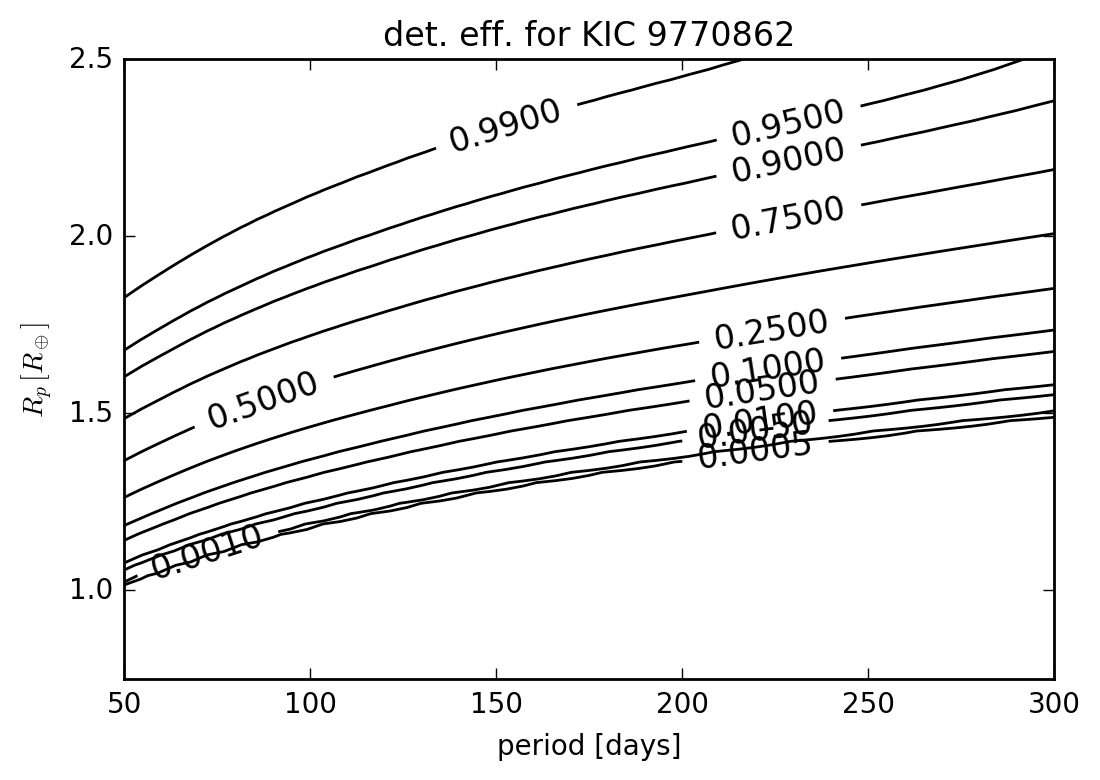

In [21]:
#%%=========================================================
# Reproducing Figure 1 from Burke paper, which is the
# completeness contour (not including geometric effect) for an example target
 
# Repeating for new insolation completeness.  
    
# Choose the first star
star = stlr[stlr.kepid == stlr.kepid.iloc[0]].iloc[0]

# Compute the completeness map on a grid.
X, Y = x_grid, rp_grid2 

if(periodInsolationSwitch == "P"):
    Z = get_completeness(star, X, Y, 0.0, catalogSwitch, with_geom=False)

elif(periodInsolationSwitch == "I"):
    Z = get_completeness_from_insolation(star, X, Y, 0.0, catalogSwitch, with_geom=False)

# Plot with the same contour levels as the figure. Add some contours at low end of completeness.
c = pl.contour(X, Y, Z, [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99], colors="k")
pl.clabel(c, fontsize=12, inline=1, fmt="%.4f") 

if(periodInsolationSwitch == "I"):
    pl.xlabel("insolation [Earth units]")
elif(periodInsolationSwitch == "P"):
    pl.xlabel("period [days]")

pl.ylabel("$R_p \, [R_\oplus]$")
pl.title("det. eff. for KIC {0}".format(np.min(stlr.kepid.iloc[0])));


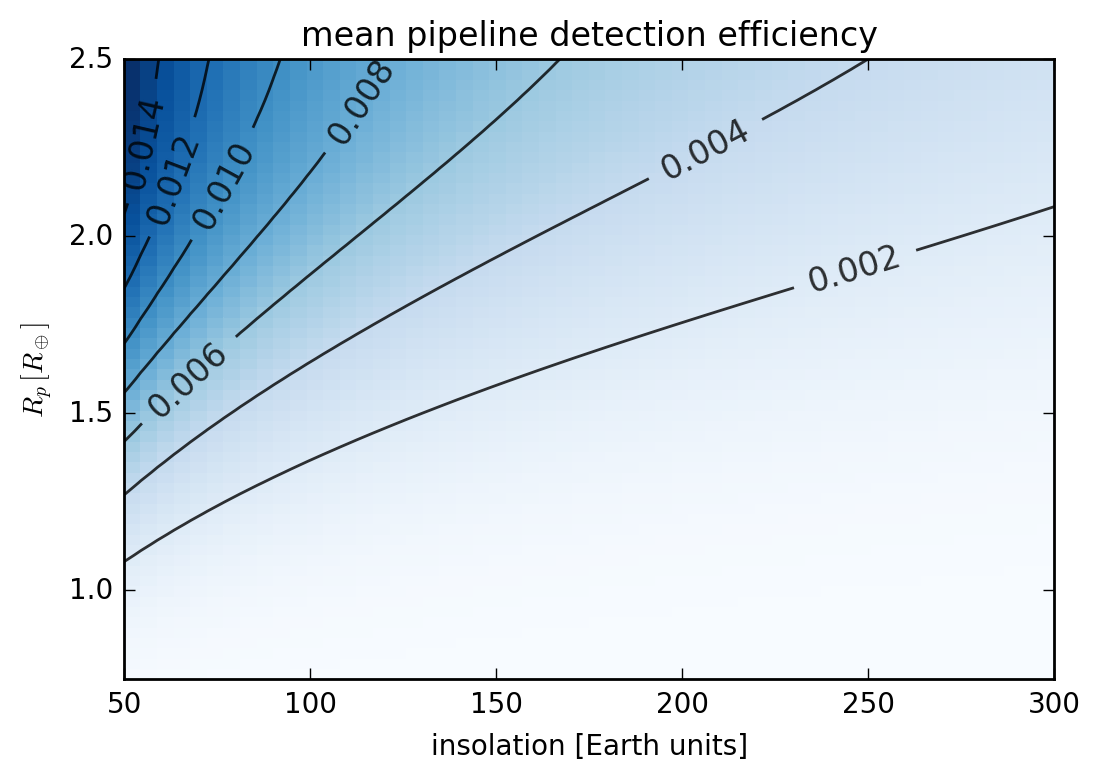

In [22]:
#%%=========================================================
# Plot the average new_completeness contour (radius-insolation)
# Include the geometric effect
pl.pcolor(x_grid, rp_grid2, new_completeness, cmap="Blues")
c = pl.contour(x_grid, rp_grid2, new_completeness / len(stlr),
               colors="k", alpha=0.8)
pl.clabel(c, fontsize=12, inline=1, fmt="%.3f")
pl.title("mean pipeline detection efficiency")
pl.xlabel("insolation [Earth units]")
pl.ylabel("$R_p \, [R_\oplus]$");


In [23]:
#%%=========================================================
# Population inference with an independent power law model
# Using modified code above that computes 
# completeness in the parameter space of [ insolation , planet radius ], 

# A double power law model for the population.
''' def population_model_insolation(theta, insolation, rp):
    # Parameters 
    # lnf0 is normalization, 
    # beta is exponent of insolation power law,
    # alpha is exponent of radius power law
    lnf0, beta, alpha = theta
    v = np.exp(lnf0) * np.ones_like(insolation)
    for x, rng, n in zip((insolation, rp),
                         (insolation_rng, rp_rng),
                         (beta, alpha)):
        n1 = n + 1
        v *= x**n*n1 / (rng[1]**n1-rng[0]**n1)
    return v
'''

# A double power law model for the population.
def population_model(theta, xLinearGrid, rp):
    # Parameters 
    # lnf0 is normalization, 
    # beta is exponent of insolation power law,
    # alpha is exponent of radius power law
    lnf0, beta, alpha = theta
    v = np.exp(lnf0) * np.ones_like(xLinearGrid)
    for x, rng, n in zip((xLinearGrid, rp),
                         (x_rng, rp_rng),
                         (beta, alpha)):
        n1 = n + 1
        v *= x**n*n1 / (rng[1]**n1-rng[0]**n1)
    return v


# The ln-likelihood function given at the top of this post.
# change to insolation from planet catalog

# Insolation and radius for planets in catalog
if(periodInsolationSwitch == "P"):
    koi_x = np.array(kois.koi_period)
elif(periodInsolationSwitch == "I"):
    koi_x = np.array(kois.koi_insol)
    
koi_rps = np.array(kois.koi_prad)

# Parameter space volume in each bin of [insolation, radius] grid
# Note the bins are not uniformly spaced in insolation
vol = np.diff(x_grid, axis=0)[:, :-1] * np.diff(rp_grid2, axis=1)[:-1, :]
def lnlike(theta):
    pop = population_model(theta, x_grid, rp_grid2) * new_completeness
    pop = 0.5 * (pop[:-1, :-1] + pop[1:, 1:])
    norm = np.sum(pop * vol)
    #print(norm)
    ll = np.sum(np.log(population_model(theta, koi_x, koi_rps))) - norm
    return ll if np.isfinite(ll) else -np.inf
# The ln-probability function is just proportional to the ln-likelihood
# since we're assuming uniform priors.
bounds = [(-5, 5), (-5, 5), (-5, 5)]
def lnprob(theta):
    # Broad uniform priors.
    for t, rng in zip(theta, bounds):
        if not rng[0] < t < rng[1]:
            return -np.inf
    return lnlike(theta)

# The negative ln-likelihood is useful for optimization.
# Optimizers want to *minimize* your function.
def nll(theta):
    ll = lnlike(theta)
    return -ll if np.isfinite(ll) else 1e15



In [24]:
#%%=========================================================
# Maximum likelihood solution by minimizing negative log-likelihood
from scipy.optimize import minimize
# Initial guess for logF, beta, and alpha
theta_0 = np.array([1, 0.66, -1.5])
#DFM original initial values below
#theta_0 = np.array([np.log(0.75), -0.53218, -1.5])

r = minimize(nll, theta_0, method="L-BFGS-B", bounds=bounds)
print(r)
# r.x is the vector of parameters (logF, beta, and alpha) from the maximum likelihood solution


      fun: 698.94983664336087
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00022737, -0.00010232,  0.00020464])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 60
      nit: 13
   status: 0
  success: True
        x: array([-0.07332613, -0.51168116, -2.1516758 ])


In [15]:
#%%=========================================================
# Plot the maximum likelihood solution

# We'll reuse these functions to plot all of our results.

# This function plots the density of samples of a double power law,
# as a function of the x0 input, marginalized over the y input
def make_plot(pop_comp, x0, x, y, ax):
    # pop_comp is a two-dimensional array of completeness values
    # pop_comp.shape is 57(insolation) x 61(radius)  
    # x0 is: bin edges of second variable (radius), for model fitting
    # x is rebinning of x0 into a coarser grid for the plots
    # y is: bin edges of first variable (insolation), for model fitting
    # Mid-bin values of the 2D array pop_comp, along the first dimension -- insolation
    pop = 0.5 * (pop_comp[:, 1:] + pop_comp[:, :-1])
    # on first call, pop is 56 x 61

    # Integrate completeness over the first variable, y, insolation
    # np.diff(y)[None, :, None] is the parameter space interval in y
    pop = np.sum(pop * np.diff(y)[None, :, None], axis=1)
    # After above command, pop is 1D, collapsed onto the radius dimension
    
    # Credible regions in x: radius
    # x is used only to get the parameter space interval dx in radius for the plot
    # Note: Assumes bin spacing np.diff(x) is uniform
    a, b, c, d, e = np.percentile(pop * np.diff(x)[0], [2.5, 16, 50, 84, 97.5], axis=0)
    # print(c)

    ax.fill_between(x0, a, e, color="k", alpha=0.1, edgecolor="none")
    ax.fill_between(x0, b, d, color="k", alpha=0.3, edgecolor="none")
    # c is the median value of the distribution over 
    ax.plot(x0, c, "k", lw=1)

def plot_results(samples):
    # Loop through the samples and compute the list of population models.
    samples = np.atleast_2d(samples)
    
    # print(samples.shape)
    # print(len(samples))
    # len(samples) is the length of the MCMC chain
    pop = np.empty((len(samples), x_grid.shape[0], x_grid.shape[1]))
    gamma_earth = np.empty((len(samples)))
    for i, p in enumerate(samples):
        # insolation_grid and rp_grid2 are meshgrids, 57x61
        # print(p)
        # print(rp_grid2.shape)
        # print(insolation_grid.shape)
        # print(i)
        # power law planet density on insolation, radius grid
        pop[i] = population_model(p, x_grid, rp_grid2)
        # planet density at the point corresponding to earth (insolation = 1 and radius = 1)
        gamma_earth[i] = population_model(p, 1.0, 1.0) * 1.0
        # print(gamma_earth[i])
        
    # Set up 4x4 grid of plots
    fig, axes = pl.subplots(2, 2, figsize=(10, 8))
    fig.subplots_adjust(wspace=0.4, hspace=0.4)
    
    # Histogram of planet radius over a new grid
    # Using a coarser grid for the plot
    dx = 5*(rp2[1] - rp2[0])
    x = np.arange(rp_rng[0], rp_rng[1] + dx, dx)
    n, _ = np.histogram(koi_rps, x)
    
    # Plot the predicted radius distribution against the observed radius distribution
    ax = axes[0, 0]
    
    # Predicted radius distribution
    # rp2 is of length 61
    # nsolation is of length 57
    # pop is 57 x 61 -- so it's insolation x radius
    # new_completeness is 1 x 57 x 61
    make_plot(pop * new_completeness[None, :, :], rp2, x, xLinearGrid, ax)
    
    # Observed radius distribution, with Poisson errors
    ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k",
                capsize=0)
    ax.set_xlim(rp_rng[0], rp_rng[1])
    ax.set_xlabel("$R_p\,[R_\oplus]$")
    ax.set_ylabel("# of detected planets")
    
    # Plot the true radius distribution.
    ax = axes[0, 1]
    make_plot(pop, rp2, x, xLinearGrid, ax)
    ax.set_xlim(rp_rng[0], rp_rng[1])
    # ax.set_ylim(0, 0.37)
    ax.set_xlabel("$R_p\,[R_\oplus]$")
    ax.set_ylabel("$\mathrm{d}N / \mathrm{d}R$; $\Delta R = 0.25\,R_\oplus$")
    
    # Histogram of insolation or period over a new grid.
    # Using a coarser grid for the plot
    dx = 5*(xLinearGrid[1] - xLinearGrid[0])
    
    x = np.arange(x_rng[0], x_rng[1] + dx, dx)
    n, _ = np.histogram(koi_x, x)
    
    # Plot the predicted insolation distribution against the observed insolation distribution
    ax = axes[1, 0]
    
    # Predicted insolation or period distribution
    make_plot(np.swapaxes(pop * new_completeness[None, :, :], 1, 2), xLinearGrid, x, rp2, ax)
    
    # Observed insolation or period distribution, with Poisson errors
    ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k",
                capsize=0)
    # ax.set_xlim(insolation_rng[0], insolation_rng[1])
    ax.set_xlim(0.5, x_rng[1])
    # ax.set_ylim(0, 25)
    ax.set_ylim(0, 40)
    
    if(periodInsolationSwitch=='I'):
        ax.set_xlabel("insolation, [Earth units]")
    elif(periodInsolationSwitch=='P'):
        ax.set_xlabel("period, [Days]")


    ax.set_ylabel("# of detected planets")
    
    # Plot the true insolation distribution.
    ax = axes[1, 1]
    make_plot(np.swapaxes(pop, 1, 2), xLinearGrid, x, rp2, ax)
    ax.set_xlim(x_rng[0], x_rng[1])
    
    if(periodInsolationSwitch=='I'):
        ax.set_ylabel("$\mathrm{d}N / \mathrm{d}I$; $\Delta I = $")
        ax.set_xlabel("insolation, [Earth units]")

    elif(periodInsolationSwitch=='P'):
        ax.set_ylabel("$\mathrm{d}N / \mathrm{d}P$; $\Delta P = $")
        ax.set_xlabel("period, [Days]")


    return gamma_earth



[ 0.06697388]


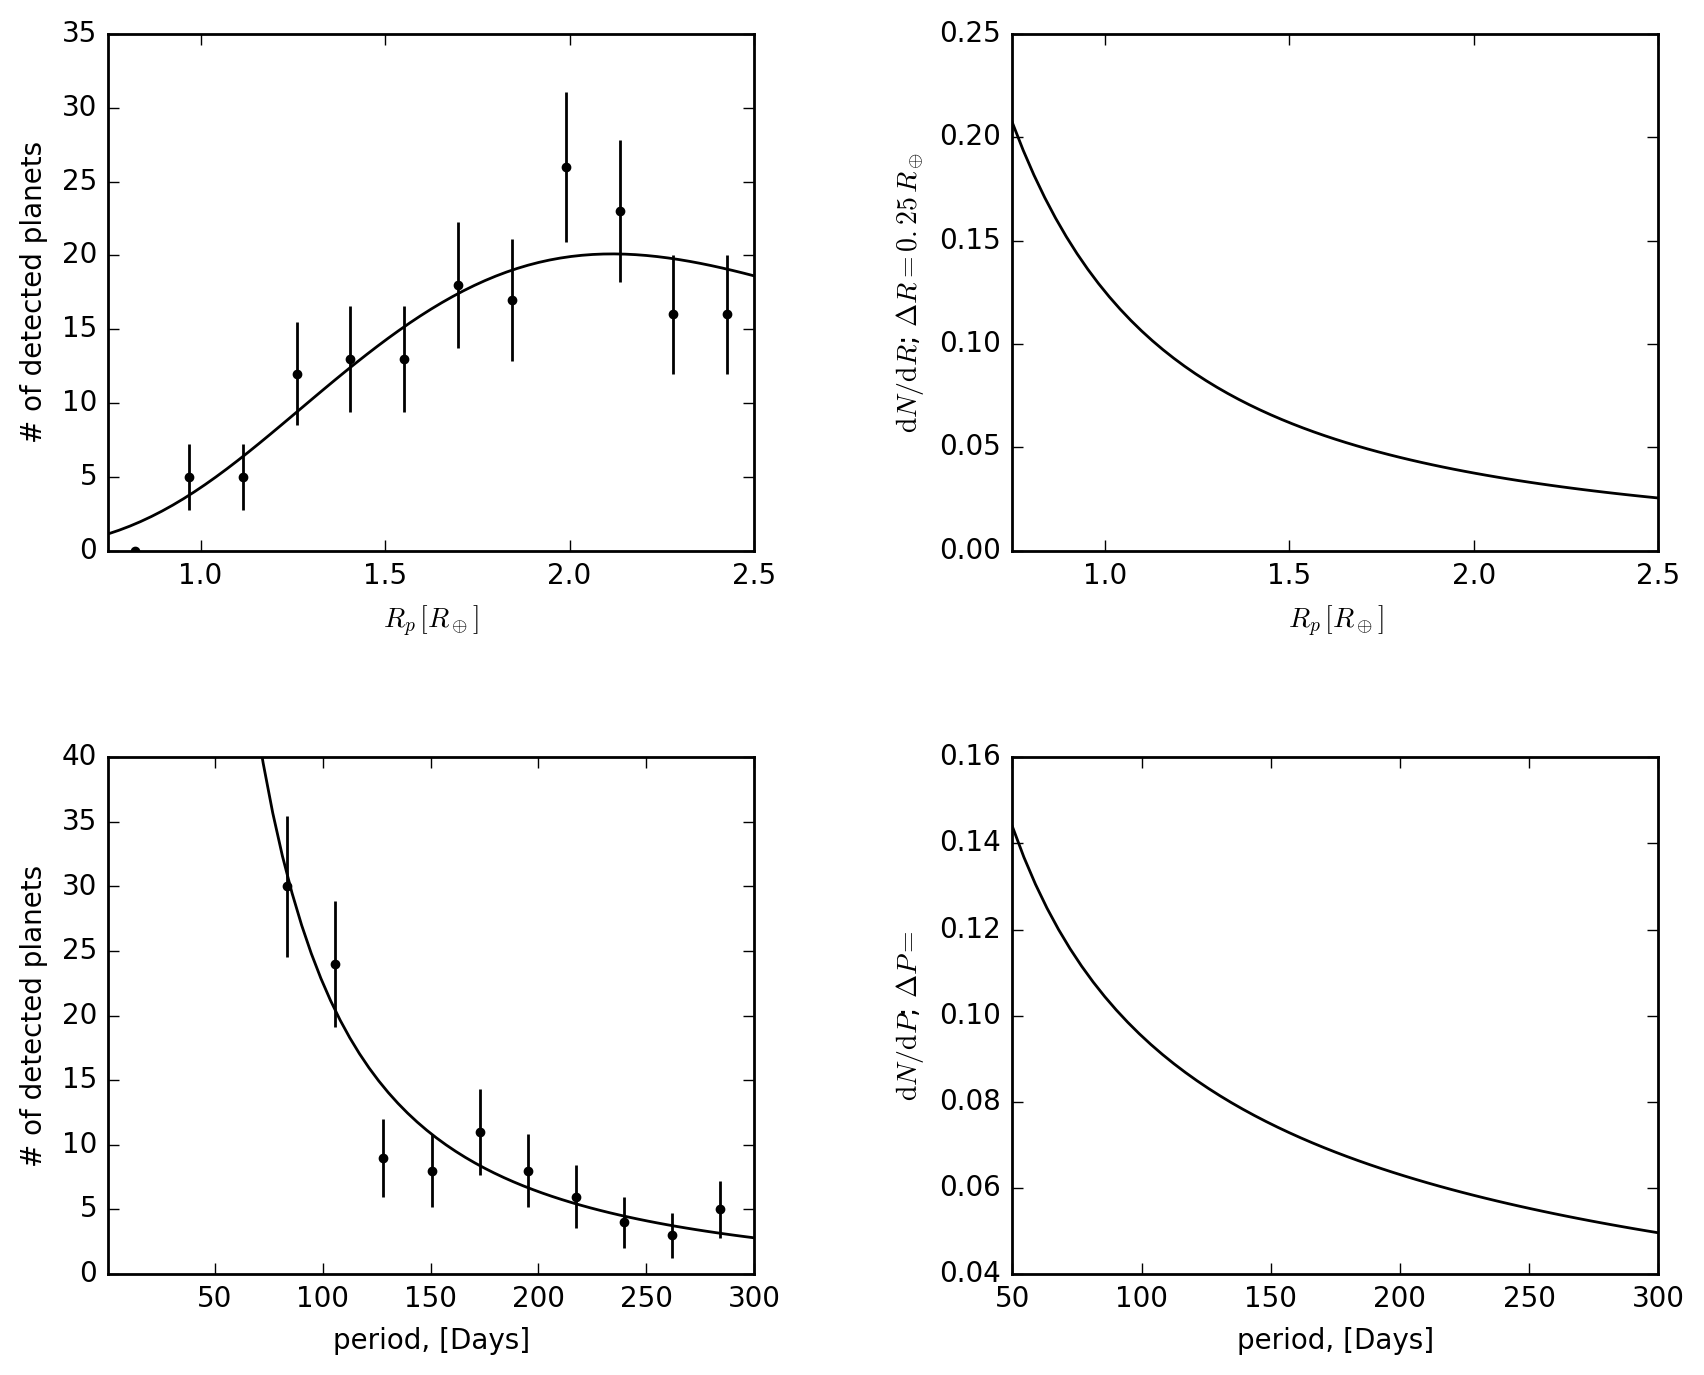

In [16]:
#%%=========================================================

# This line calls the plotting machinery above, and returns the maximum likelihood value of gamma_earth
# Note that r.x is the set of parameters [ lnf0, beta, alpha ] returned by the maximum likelihood fit
print(plot_results(r.x));

# Or, try your own values for the parameters, e.g.
# thetaTry = np.array([.01, -1.2, -1.1])
# print(plot_results(thetaTry));

In [19]:
#%%=========================================================
# Sample from the posterior probability distribution for the population parameters using emcee
import emcee

ndim, nwalkers = len(r.x), 16

# Initialize, and set trial vector as Max Likelihood solution perturbed by a small random vector
pos = [r.x + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

# specify number of samples and number of burn-in samples
nSamplesPerChain = 4000
nBurnIn = nSamplesPerChain/4
nChains = nwalkers

# Burn in.
pos, _, _ = sampler.run_mcmc(pos, nBurnIn)
sampler.reset()

# Production.
pos, _, _ = sampler.run_mcmc(pos, nSamplesPerChain)



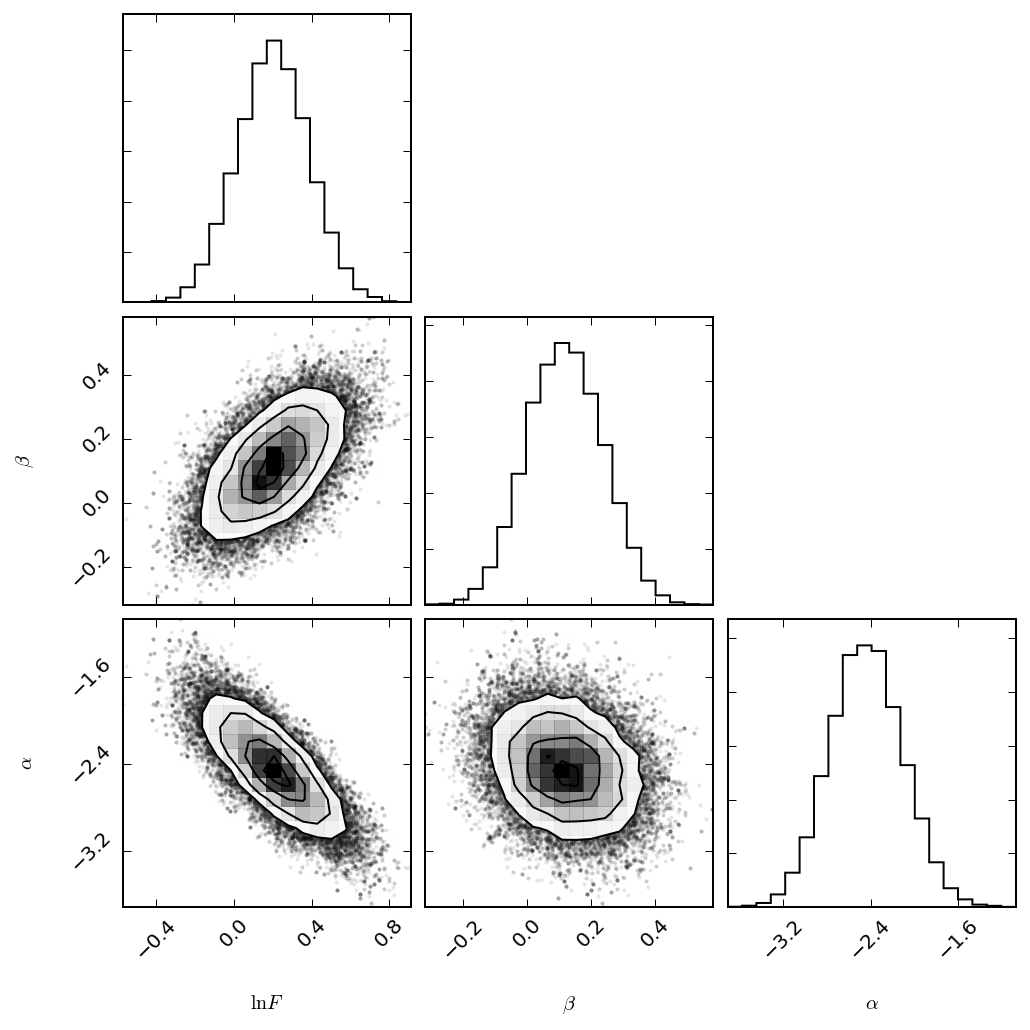

In [20]:
#%%=========================================================
# Triangle plot of PDFs using DFMs corner package
import corner
corner.corner(sampler.flatchain, labels=[r"$\ln F$", r"$\beta$", r"$\alpha$"]);


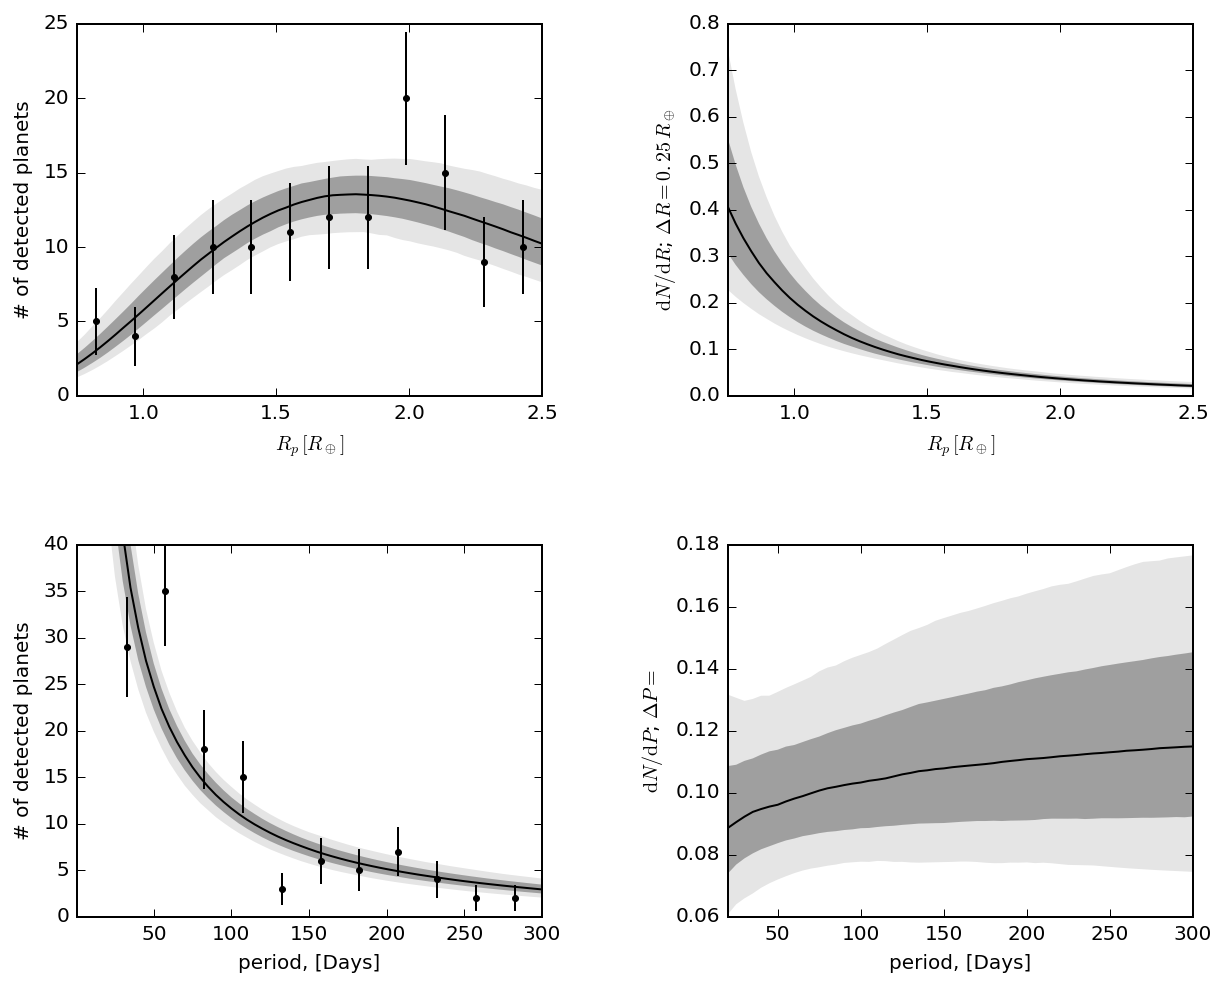

In [21]:
#%%=========================================================
# Plot marginalized posteriors of N and dN/dR
# For Rp, marginalize over P
# For P, marginalize over Rp
# For N, plot also the data and the error bars

# Problem -- plotting all the chains maxes out my PCs memory.    
# Solution -- plot only the last 4000 chains 
gamma_earth = plot_results(sampler.flatchain[60000:63999,:])


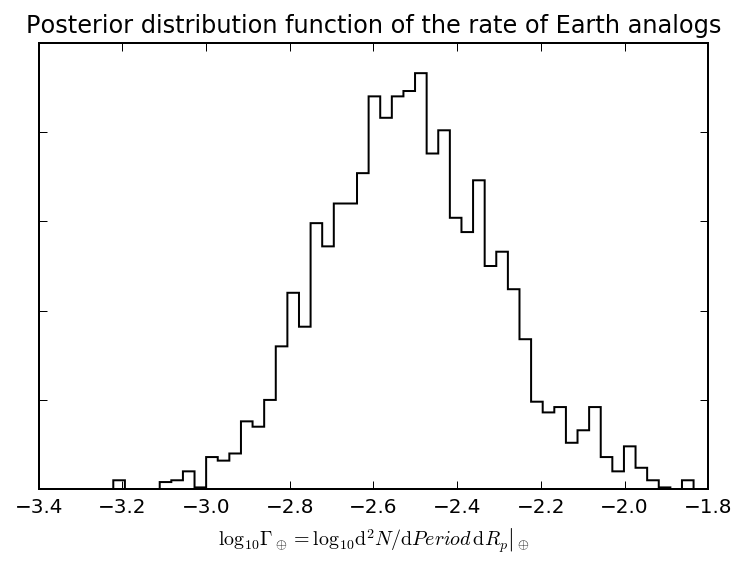

In [22]:
#%%=========================================================
# Posterior distribution of log10 gamma_earth
pl.hist(np.log10(gamma_earth), 50, histtype="step", color="k")
pl.gca().set_yticklabels([])
pl.title("Posterior distribution function of the rate of Earth analogs")
# pl.xlabel(r"$\log_{10}\Gamma_\oplus $");

if(periodInsolationSwitch == 'I'):
    pl.xlabel(r"$\log_{10}\Gamma_\oplus = \left. \log_{10}\mathrm{d}^2 N / \mathrm{d} Insolation \, \mathrm{d} R_p \right |_\oplus$");
elif(periodInsolationSwitch == 'P'):
    pl.xlabel(r"$\log_{10}\Gamma_\oplus = \left. \log_{10}\mathrm{d}^2 N / \mathrm{d} Period \, \mathrm{d} R_p \right |_\oplus$");



16, 50, 84 percentile range for integrated gamma = [ 0.21120315  0.26374517  0.32717729] 


(0, 1)

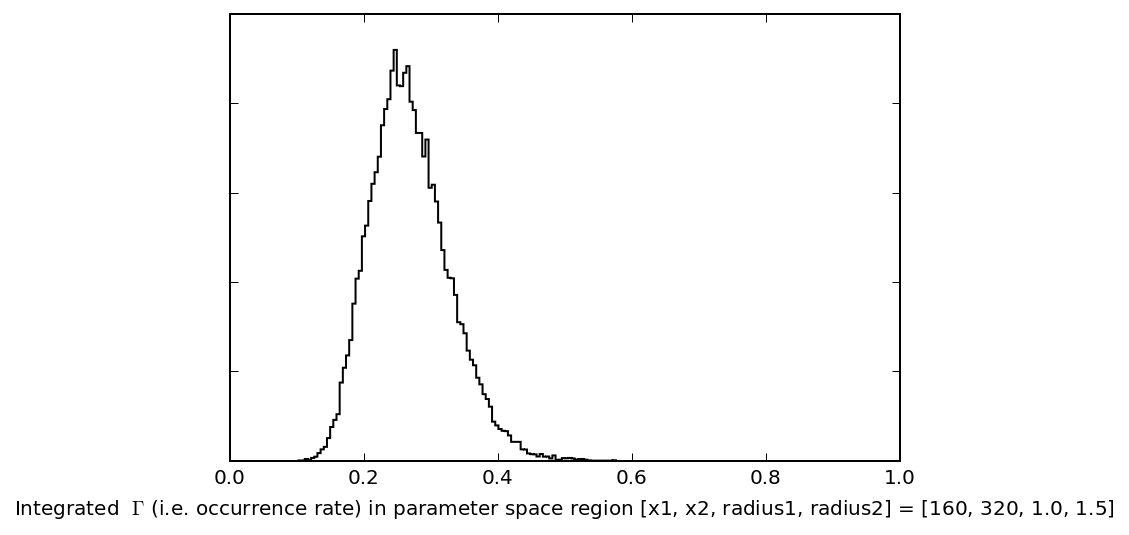

In [23]:

#%%=========================================================
# Integrate the planet density over a given range in insolation and radius
#   to get the exoplanet occurrence rate predicted by the power law in that region

def integrated_gamma(theta,x1,x2,radius1,radius2,periodInsolationSwitch):
    
    # Break out parameters 
    lnf0, beta, alpha = theta
    
    # Phase space boundaries for our model
    if(periodInsolationSwitch == 'P'):
        x_rng = (50, 300)
    elif(periodInsolationSwitch == 'I'):
        x_rng = (0.2, 20)
            
    radius_rng = (0.75, 2.5)
    
    # Compute exoplanet occurrence rate integrated over chosen region of [ x , radius] parameter space
    integral_over_x = (x2**(beta + 1) - x1**(beta + 1))/(x_rng[1]**(beta + 1) - x_rng[0]**(beta + 1))
    integral_over_radius = (radius2**(alpha + 1) - radius1**(alpha + 1))/(radius_rng[1]**(alpha + 1) - radius_rng[0]**(alpha + 1))
    eta = integral_over_x*integral_over_radius*np.exp(lnf0)
    
    return eta
    

#%%=========================================================
#  Compute and plot the posterior PDF for the exoplanet occurence rate in a 
#   desired region of period, radius parameter space
#   NOTE: using SAG-13 binning scheme

# Initialize   
int_gamma_samples = np.empty(len(sampler.flatchain))


# !!!!! Choose period or insolation bin edges (according to stellar type), for occurrence rate calculation
if(periodInsolationSwitch == 'I'):

    if(stellarTypeSwitch == 'A'):
        # Select A dwarfs
        # !!!!! Using same range as for G dwarfs, for now
        x1 = 0.295
        x2 = 1.824
        
    elif(stellarTypeSwitch == 'F'):
        # Select F dwarfs
        # !!!!! Using same range as for G dwarfs, for now
        x1 = 0.295
        x2 = 1.824

    elif(stellarTypeSwitch == 'G'):
        # Select G dwarfs
        x1 = 0.295
        x2 = 1.824
       
    elif(stellarTypeSwitch == 'K'):
        # Select K dwarfs
        x1 = 0.235
        x2 = 1.681

    elif(stellarTypeSwitch == 'M'):
        # Select M dwarfs
        x1 = 0.205
        x2 = 1.514

elif(periodInsolationSwitch == 'P'):
    
    x1 = 160
    x2 = 320

# !!!!! Choose radius bin edges for occurrence rate calculation
radius1 = 1.0
radius2 = 1.5

# Integrate the gamma posterior distribution over the selected phase space bin
# NOTE -- This gives the exoplanet occurrence rate in that phase space bin!
for i, theta in enumerate(sampler.flatchain):
    int_gamma_samples[i] = integrated_gamma(theta,x1,x2,radius1,radius2,periodInsolationSwitch)

# print occurrence rate for this parameter space region
print("16, 50, 84 percentile range for integrated gamma = {0} ".format(np.percentile(int_gamma_samples,[16,50,84])))

# Plot the posterior of int gamma_samples over selected planet radius and period range             
pl.hist(int_gamma_samples, 100, histtype="step", color="k")
pl.gca().set_yticklabels([])
if(periodInsolationSwitch == 'I'):
    pl.title("Integrated ocurrence rate over radius and insolation")
elif(periodInsolationSwitch == 'I'):
    pl.title("Integrated ocurrence rate over radius and period")
    
pl.xlabel(r"Integrated  $\Gamma$ (i.e. occurrence rate) in parameter space region [x1, x2, radius1, radius2] = {0}".format([x1,x2,radius1,radius2]));    
# pl.xlabel(r"$\log_{10}\Gamma_\oplus = \left. \log_{10}\mathrm{d}N / \mathrm{d}\ln P \, \mathrm{d}\ln R_p \right |_\oplus$");
pl.xticks
pl.gca().set_xlim([0,1])


                                                




In [24]:
#=====================================================================
# Gather and save occurrence rate data for emcee sampler
# Could make this a function which takes as inputs
# the posterior samples array 
# the names of the files to save to
# nSamplesPerChain
# nChains
samples = sampler.flatchain

# Define radius and period bin edges
radiusBinEdges = [0.67, 1.0, 1.5, 2.3, 3.4, 5.1, 7.6, 11, 17]
periodBinEdges = [10, 20, 40, 80, 160, 320, 640]

# Initialize dictionary
# occurrenceRateData = dict()

# Initialize lists for median, lower and upper occ rate limits
listMedian = [None]*(len(radiusBinEdges)-1)
listLowerCredibleInterval = [None]*(len(radiusBinEdges)-1)
listUpperCredibleInterval = [None]*(len(radiusBinEdges)-1)

# Loop over desired period and radius bins and compute occurrence rates
for iRadius in range(len(radiusBinEdges)-1):
    # Initialize lists for rows
    listMedianRow = []
    listLowerCredibleIntervalRow = []
    listUpperCredibleIntervalRow = []
    for iPeriod in range(len(periodBinEdges)-1):
        # Integrate the gamma posterior distribution over the selected phase space bin
        # NOTE -- This gives the exoplanet occurrence rate in that phase space bin
        int_gamma_samples = [None]*(len(samples))
        for i, theta in enumerate(samples):
            int_gamma_samples[i] = integrated_gamma(theta,periodBinEdges[iPeriod],periodBinEdges[iPeriod+1],
                                                   radiusBinEdges[iRadius],radiusBinEdges[iRadius+1],periodInsolationSwitch)

        # Print result for this bin
        print("\nRadius Bin "+str(radiusBinEdges[iRadius])+" to "+str(radiusBinEdges[iRadius+1])+" , Period Bin "+str(periodBinEdges[iPeriod])+" to "+str(periodBinEdges[iPeriod+1]))
        print("     Occurrence rate 16, 50, 84 percentile range : {0} ".format(np.percentile(int_gamma_samples,[16,50,84])))

        # Populate the dictionary with the result for this bin
        # binKey = "bin_" + str(radiusBinEdges[iRadius]) + "_" + str(periodBinEdges[iPeriod])
        # occurrenceRateData[binKey] = np.percentile(int_gamma_samples,[16,50,84])
        
        # Accumulate a row vector of median occurrence rates and their upper and lower credible intervals
        # for period bins at this radius
        listMedianRow.append(np.percentile(int_gamma_samples,[50]))
        listLowerCredibleIntervalRow.append(np.percentile(int_gamma_samples,[16]))
        listUpperCredibleIntervalRow.append(np.percentile(int_gamma_samples,[84]))
              
    # Append the row vector of results into the arrays for the median and lower and upper occ rate limits
    listMedian[iRadius] = listMedianRow
    listLowerCredibleInterval[iRadius] = listLowerCredibleIntervalRow
    listUpperCredibleInterval[iRadius] = listUpperCredibleIntervalRow
        
# Save the dictionary
#with open('occurrence_rate_data_'+stellarTypeSwitch+'_'+catalogSwitch+'.pkl', 'wb') as handle:
#    pickle.dump(occurrenceRateData, handle)
    
# Save the .csv files
np.savetxt('eta_emcee_occurrence_rate_median_'+str(nSamplesPerChain)+'_samples_per_chain_'+str(nChains)+'_chains_'+stellarTypeSwitch+'_'+catalogSwitch+'.csv', np.array(listMedian), delimiter=",",fmt='%.5f')
np.savetxt('sigma_n_emcee_occurrence_rate_lower_credible_interval_'+str(nSamplesPerChain)+'_samples_per_chain_'+str(nChains)+'_chains_'+stellarTypeSwitch+'_'+catalogSwitch+'.csv', np.array(listLowerCredibleInterval), delimiter=",",fmt='%.5f')
np.savetxt('sigma_p_emcee_occurrence_rate_upper_credible_interval_'+str(nSamplesPerChain)+'_samples_per_chain_'+str(nChains)+'_chains_'+stellarTypeSwitch+'_'+catalogSwitch+'.csv', np.array(listUpperCredibleInterval), delimiter=",",fmt='%.5f')




Radius Bin 0.67 to 1.0 , Period Bin 10 to 20
     Occurrence rate 16, 50, 84 percentile range : [ 0.01551238  0.02080458  0.02768298] 

Radius Bin 0.67 to 1.0 , Period Bin 20 to 40
     Occurrence rate 16, 50, 84 percentile range : [ 0.03475549  0.04525452  0.05858297] 

Radius Bin 0.67 to 1.0 , Period Bin 40 to 80
     Occurrence rate 16, 50, 84 percentile range : [ 0.07556176  0.09839754  0.12713144] 

Radius Bin 0.67 to 1.0 , Period Bin 80 to 160
     Occurrence rate 16, 50, 84 percentile range : [ 0.16017183  0.21413199  0.28245658] 

Radius Bin 0.67 to 1.0 , Period Bin 160 to 320
     Occurrence rate 16, 50, 84 percentile range : [ 0.33381145  0.46630814  0.63871305] 

Radius Bin 0.67 to 1.0 , Period Bin 320 to 640
     Occurrence rate 16, 50, 84 percentile range : [ 0.68779296  1.01301558  1.46691674] 

Radius Bin 1.0 to 1.5 , Period Bin 10 to 20
     Occurrence rate 16, 50, 84 percentile range : [ 0.00948676  0.01181845  0.01454842] 

Radius Bin 1.0 to 1.5 , Period Bin 20 to 40

##  
ABC pseudocode 
1. Simulate population based on power law lnf0, alpha, beta. Draw lnf0, alpha, beta from uniform priors.
   Draw 1 planet per catalog star to produce TRUE catalog. 
2. Apply selection effects via completeness to produce SIMULATED catalog
3. Compare with OBSERVED catalog.
   Form kernel density maps for both OBSERVED and SIMULATED catalogs
   A. Distance metric is quadrature sum of point-by-point abs difference of kernel density estimates at phase space
      points associated with planets in OBSERVED catalog 
   B. Accept SIMULATED catalog based on whether distance metric is below epsilon threshold
4. Repeat steps 1 - 3 until there are K accepted simulated catalogs where K is say 20
    Adaptive step:
    set new threshold to the 75th percentile of the K epsilons,
    
The algorithm for PMC (Population Monte Carlo) ABC is from Beaumont et al. 2008 https://arxiv.org/pdf/0805.2256v9.pdf page 5.


Next: 
    -- Modify by adding radius errors to true catalog



Ensemble number 0
Catalog number 0
Catalog number 1
Catalog number 2
Catalog number 3
Catalog number 4
Catalog number 5
Catalog number 6
Catalog number 7
Catalog number 8
Catalog number 9
Catalog number 10
Catalog number 11
Catalog number 12
Catalog number 13
Catalog number 14
Catalog number 15
Catalog number 16
Catalog number 17
Catalog number 18
Catalog number 19
Catalog number 20
Catalog number 21
Catalog number 22
Catalog number 23
Catalog number 24
Catalog number 25
Catalog number 26
Catalog number 27
Catalog number 28
Catalog number 29
Catalog number 30
Catalog number 31
Catalog number 32
Catalog number 33
Catalog number 34
Catalog number 35
Catalog number 36
Catalog number 37
Catalog number 38
Catalog number 39
Catalog number 40
Catalog number 41
Catalog number 42
Catalog number 43
Catalog number 44
Catalog number 45
Catalog number 46
Catalog number 47
Catalog number 48
Catalog number 49
Catalog number 50
Catalog number 51
Catalog number 52
Catalog number 53
Catalog number 54
Ca

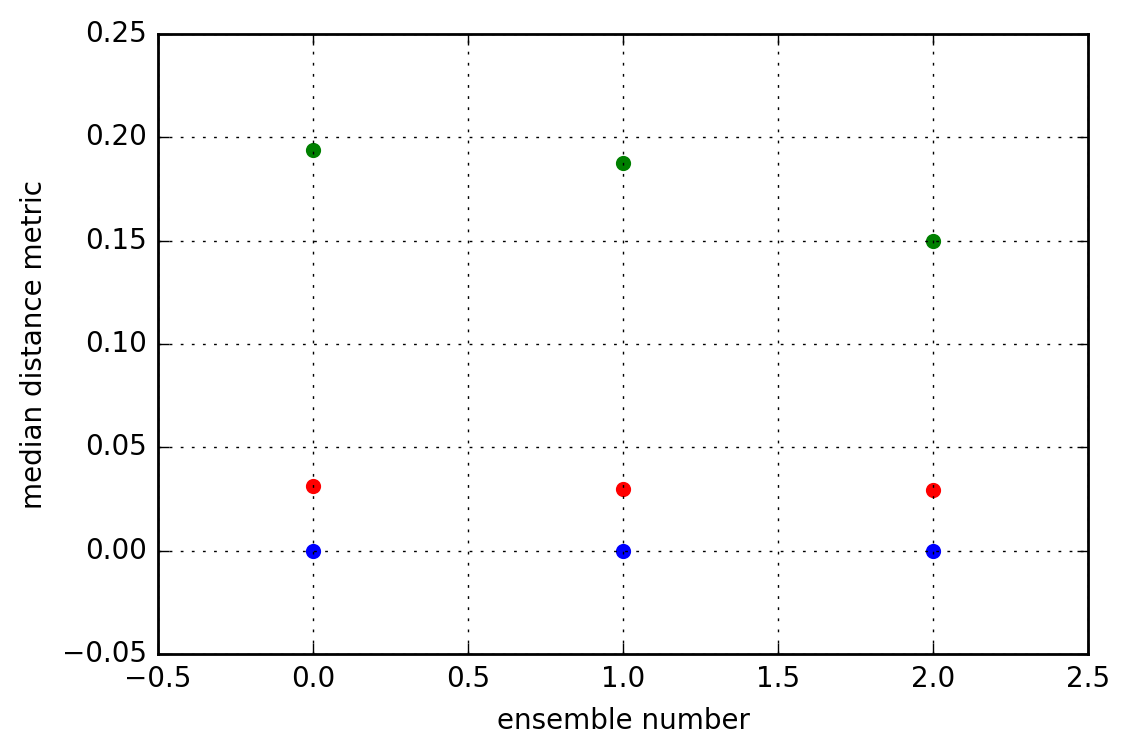

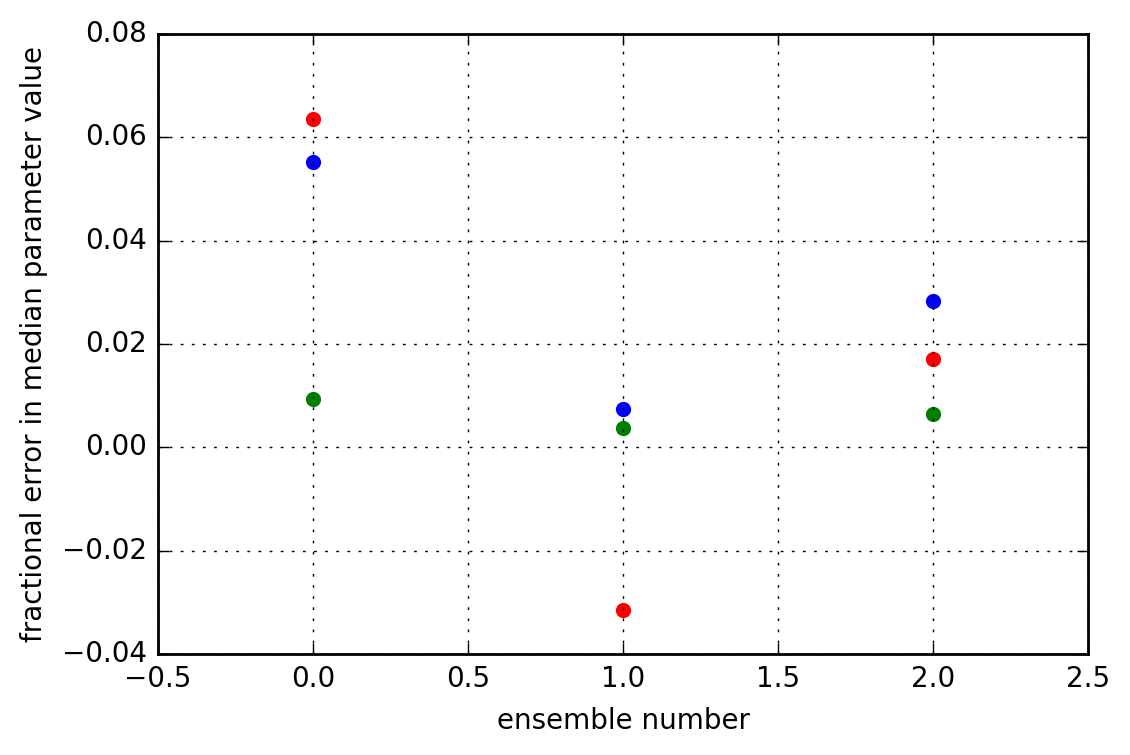

In [699]:
import numpy as np
import scipy.interpolate as interp
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

def draw_simulated_catalog(nStars, rMin, rMax, pMin, pMax, interpObj, Gamma=None, alpha=None, beta=None):
    """ 
    Inputs:
        nStars is the number of targets in the star catalog
        rMin and rMax are minimum and maximum planet radii
        pMin and pMax are minimum and maximum orbit period
        alpha is radius power law index
        beta is period power law index
        Gamma (=exp(lnf0))is a scale parameter giving the expected number of planets/star in the catalog

    Outputs:
        Returns a simulated catalog, which is a list of [period, radius]
        
     """
    
    #  Gamma parameter assumed <=1
            
    # Draw a planet for each star in the catalog
    [P, R] = draw_planet(alpha, beta, rMin, rMax, pMin, pMax, nStars )
       
    # Populate the true catalog -- decide which stars have planets
    # Gamma is the scale factor we want to infer for the power law: assume it is < 1
    #    because it's consistent with the data
    # !!!!! What if Gamma > 1 ? (Not yet implemented)
    #    First accept floor(Gamma) draws
    #    Then treat the *remainder* as Gamma in the section below
    # Draw a random uniform variate U, and use it to decide which stars get planets
    # If U < Gamma, draw a planet [period,radius] from the true density joint power law PDF
    # The power law PDFs for radius and period should be normalized over the desired region of phase space
    # bounded by 50 < P < 300 and 0.75 < R < 2.5
    
    # Indicator for populating a star with the drawn planet for the true catalog
    idxTrue = np.random.uniform(0,1,nStars) < Gamma
        
    # Initialize completeness for planets in true catalog
    C = np.zeros(nStars)
    
    # Interpolate completeness (average number of planets per star) at R and P for planets in the true catalog
    # !!!!! Note that order of the inputs is reversed for the RectBivariateSpline interpolator
    # grid=False if you want to interpolate only at a set of point, not the whole grid
    C[idxTrue] = interpObj(P[idxTrue],R[idxTrue],grid=False)
    
    # Apply the selection effects (encoded in the completeness grid) to decide whether the 
    #      planet should be added to the simulated catalog
    
    # Draw a uniform random variate V to decide whether the planet is detected
    # Detect the planet and add it to the simulated catalog if V < C(P,R)
    idxDetected = np.random.uniform(0,1,nStars) < C
    
    # Make the simulated catalog
    simulatedCatalog = [P[idxDetected], R[idxDetected] ]
    
    return simulatedCatalog

def draw_planet(alpha, beta, rMin, rMax, pMin, pMax, nDraw):
    """
    Returns an ensemble of (P, R) of planets drawn from a joint power law in radius and period
    nDraw is the number of planets to draw
    """
    # Normalized cumulative distributions
    R = invCumDist(alpha,rMin,rMax,nDraw)
    P = invCumDist(beta,pMin,pMax,nDraw)
    return P, R

def invCumDist(gamma,xMin,xMax,nDraw):
    """
    Returns an ensemble of samples drawn from a power law distribution
    nDraw is the number of samples in the ensemble
    
    Power law number density is P ~ X**gamma, over range xMin, xMax
    normalizedCumDist = (X**(gamma + 1) - xMin**(gamma + 1))/( xMax**(gamma + 1) - xMin**(gamma + 1) )
    
    !!!!! Caution: Still need to handle the corner case of exponents near gamma = -1 !!!!!
    """
    
    # U is a uniform random deviate
    U = np.random.uniform(0,1,nDraw)
    
    # This function maps U into a sample from a normalized power law distribution
    #    via "Inverse CDF method"
    X = ( U * (xMax**( gamma + 1 ) - xMin**( gamma + 1 )) + xMin**( gamma + 1 ) )**( 1/( gamma + 1 ) )
    return X

def abcDistance(simulatedCatalog,observedCatalog,rMin,rMax,pMin,pMax,distanceMetric=None,nBins=None,useKDE=None):
    """
    Returns either Hellinger distances between histograms,
    or L2 distances between empirical CDFs for R and P catalogs,
    and the fractional distance between catalogs for Gamma
    
    Catalogs are assumed to be lists of [R,P]
    
    """
    
    # Extract period and radius from catalogs
    pObserved = observedCatalog[0]
    rObserved = observedCatalog[1]
    pSimulated = simulatedCatalog[0]
    rSimulated = simulatedCatalog[1]
    # print([len(rObserved),len(rSimulated)])
    
    # Number of objects contained in each catalog
    nSimulated = len(simulatedCatalog[0])
    nObserved = len(observedCatalog[0])
    
    # Specify distance metric -- H for Hellinger, K for Kolmogorov
    if(distanceMetric == 'H'):
    
        # !!!!! Hellinger distance -- applicable to PDFs.
        # !!!!! Jessi, Eric, and Tom suggested to do kernel density estimation to get the PDF
        # Here, PDFs of R and P are estimated by histograms
    
        if(not useKDE):
        
            # Probability distributions of period and radius in observed catalog
            probPobserved, pBinsObserved = np.histogram(pObserved, bins = np.linspace(pMin,pMax,nBins), density = True)
            probRobserved, rBinsObserved = np.histogram(rObserved, bins = np.linspace(rMin,rMax,nBins), density = True)
    
            # Probability distributions of period and radius in observed catalog
            probPsimulated, pBinsSimulated = np.histogram(pSimulated, bins = np.linspace(pMin,pMax,nBins), density = True)
            probRsimulated, rBinsSimulated = np.histogram(rSimulated, bins = np.linspace(rMin,rMax,nBins), density = True)

            # Bin spacing in R and P
            dP = pBinsObserved[1] - pBinsObserved[0]
            dR = rBinsObserved[1] - rBinsObserved[0]
        
    
            # print(sum(probPobserved*dP))
            # print(sum(probRobserved*dR))
        
            # Squared Hellinger distances for R and P discrete PDFs
            # distance scale should be indep of number of bins
            rDistance = 0.5*np.sum( ( np.sqrt(probRsimulated*dR) - np.sqrt(probRobserved*dR) )**2 )
            pDistance = 0.5*np.sum( ( np.sqrt(probPsimulated*dP) - np.sqrt(probPobserved*dP) )**2 ) 
    
            # Handle cases of nans. Note sure why this happens?
            if(np.isnan(rDistance)):   
                rDistance = 100000
            if(np.isnan(pDistance)):   
                pDistance = 100000
                
        else:
            
            # Use KDE to compute Hellinger distances
            
            # Bandwidth selection via Silverman's rule of thumb 
            # ref: https://en.wikipedia.org/wiki/Kernel_density_estimation
            bw_rObserved = np.std(rObserved)*( 4./3./float(len(rObserved)))**(1./5.); 
            bw_rSimulated = np.std(rSimulated)*( 4./3./float(len(rSimulated)))**(1./5.); 
            bw_pObserved = np.std(pObserved)*( 4./3./float(len(pObserved)))**(1./5.); 
            bw_pSimulated = np.std(pSimulated)*( 4./3./float(len(pSimulated)))**(1./5.); 
            
            # Grids for R and P
            nGrid = 1000
            P_plot= np.linspace(pMin,pMax,nGrid).reshape(-1,1)
            dP = P_plot[1] - P_plot[0]

            R_plot= np.linspace(rMin,rMax,nGrid).reshape(-1,1)
            dR = R_plot[1] - R_plot[0]

            kde_pObserved = KernelDensity(kernel='gaussian', bandwidth=bw_pObserved).fit(pObserved.reshape(-1,1))
            log_dens_pObserved = kde_pObserved.score_samples(P_plot)
            prob_pObserved = np.exp(log_dens_pObserved)

            kde_pSimulated = KernelDensity(kernel='gaussian', bandwidth=bw_pSimulated).fit(pSimulated.reshape(-1,1))
            log_dens_pSimulated = kde_pSimulated.score_samples(P_plot)
            prob_pSimulated = np.exp(log_dens_pSimulated)

            kde_rObserved = KernelDensity(kernel='gaussian', bandwidth=bw_rObserved).fit(rObserved.reshape(-1,1))
            log_dens_rObserved = kde_rObserved.score_samples(R_plot)
            prob_rObserved = np.exp(log_dens_rObserved)

            kde_rSimulated = KernelDensity(kernel='gaussian', bandwidth=bw_rSimulated).fit(rSimulated.reshape(-1,1))
            log_dens_rSimulated = kde_rSimulated.score_samples(R_plot)
            prob_rSimulated = np.exp(log_dens_rSimulated)
            
            # KDE distances
            rDistance = 0.5*np.sum( ( np.sqrt(prob_rSimulated*dR) - np.sqrt(prob_rObserved*dR) )**2 )
            pDistance = 0.5*np.sum( ( np.sqrt(prob_pSimulated*dP) - np.sqrt(prob_pObserved*dP) )**2 ) 
            
    #elif(distanceMetric == 'K'):
        
        # Empirical CDF distance. Provides a sufficient statistic.
        # Not implemented yet
        # The idea:
        # Sort the radii (or periods)
        # Find smallest difference Dmin and make a grid over [min,max] radii, with grid spacing = 0.5*Dmin
        # loop over grid elements Ri, and compute unnormalized CDF =  sum(Ni = r < Ri)
        # {Ni} is a suficient statistic to represent the {Ri}
        # Now compute distance metric between observed and simulated catalog, which can be
        # the RMS difference between the unnormalized CDFs
        # Jessi Cisewski suggested that smoothing would work better.
    
    
    # Distance is absolute fractional difference
    nDistance = np.abs((float(nSimulated - nObserved))/float(nObserved))
    # print(nObserved)
    # print(nSimulated)
                                  
    return rDistance, pDistance, nDistance
    

#=====================================
if __name__ == '__main__':
    
    import time
    from sklearn.neighbors import KernelDensity

    # Approximate Bayesian Computation (ABC) inference of the population-level parameters

    # Control parameters
    nEnsembles = 3
    nCatalogs = 100
    nDistanceBins = 10
    useKDE = True

    # Acceptance percentile for distance thresholds
    acceptancePctile = 75
    
    # Initialize parameters to their max likelihood values
    # alpha and beta are the radius and period power law indices
    # Gamma is the number of planets per star within phase space defined by boundaries [rMin,rMax] and [pMin,pMax]
    alphaML = -2.15
    betaML = -0.51
    GammaML = np.exp(-0.2)
    
    epsilonRinit = 2
    epsilonPinit = 2
    epsilonGammaInit = 2
    
    
    # Width of uniform priors
    dGamma = 0.1*np.abs(GammaML)   #0.08
    dBeta = 0.5*np.abs(betaML)     #0.05
    dAlpha = 0.5*np.abs(alphaML)   #0.2
    
    # Option to generate a "known" observed catalog instead of using the observations
    generateFakeObservedCatalog = True #bool(raw_input("Generate fake observed catalog? 1 or 0 -- "))
    
    # Option to do PMC vs. naive ABC
    pmcMode = False #bool(raw_input("PMC ABC? 1 or 0 -- "))
    
    # Period-radius phase space boundaries
    #!!!!! if these are treated as bin centers, 
    # we need to adjust the phase space volume to include out to the bin edges at the phase space boundaries
    rMin = rp_rng[0]
    rMax = rp_rng[1]
    pMin = x_rng[0]
    pMax = x_rng[1]

    # Number of stars in stellar catalog
    nStars = len(stlr)
    
    # Radius and period grids
    # !!!!! The rp2 and period grids should be treated as bin centers, not bin edges
    #       because the completeness grid values are computed at these values of radius and period
    radiusBinCenters = rp2 #(rp2[0:-1] + rp2[1:])/2
    periodBinCenters = period #(period[0:-1] + period[1:])/2

    # Completeness grid, normalized by number of stars that contributed
    completeness = new_completeness/nStars

    # Completeness interpolation object    
    # Use Rectangular Bivariate Spline -- fast
    # !!!!! Note that order of the x,y inputs is reversed for the RectBivariateSpline interpolator
    interpObj = interp.RectBivariateSpline(periodBinCenters, radiusBinCenters, completeness, kx=2, ky=2, s=0)

    # Observed planet catalog
    if(generateFakeObservedCatalog):
        # Generate fake observed catalog with parameters at their ML values
        observedCatalog = draw_simulated_catalog(nStars, rMin, rMax, pMin, pMax, interpObj, Gamma=GammaML,alpha=alphaML,beta=betaML)
    else:
        observedCatalog = [np.asarray(kois.koi_period), np.asarray(kois.koi_prad)]
 
    # Generate ensembles of simulated catalogs
    # Adjusting distance threshold epsilon adaptively
    
    # Initialize for loop over ensembles of simulated catalog
    epsilonR = np.zeros(nEnsembles)
    epsilonP = np.zeros(nEnsembles)
    epsilonGamma = np.zeros(nEnsembles)
    dSquaredRAll = [None]*nEnsembles
    dSquaredPAll = [None]*nEnsembles
    dSquaredGammaAll = [None]*nEnsembles
    alphaAll = [None]*nEnsembles
    betaAll = [None]*nEnsembles
    GammaAll = [None]*nEnsembles
    weights_Gamma = [None]*nEnsembles
    weights_alpha = [None]*nEnsembles
    weights_beta = [None]*nEnsembles
    tau_Gamma = [None]*nEnsembles
    tau_alpha = [None]*nEnsembles
    tau_beta = [None]*nEnsembles

    # Loop over ensembles of simulated catalogs
    for jEnsemble in range(nEnsembles):
    
        print('Ensemble number ' + str(jEnsemble))
        
        # Initialize for loop over simulated catalogs
        dSquaredR = np.zeros(nCatalogs)
        dSquaredP = np.zeros(nCatalogs)
        dSquaredGamma = np.zeros(nCatalogs)
        alpha = np.zeros(nCatalogs)
        beta = np.zeros(nCatalogs)
        Gamma = np.zeros(nCatalogs)
        
        # Start clock for this ensemble
        init_time = time.time()
        
        # Set epsilon thresholds for first ensemble of catalogs
        if(jEnsemble == 0):
            epsilonR[jEnsemble] = epsilonRinit
            epsilonP[jEnsemble] = epsilonPinit
            epsilonGamma[jEnsemble] = epsilonGammaInit
            
        # Draw the theta_star vector (length = nCatalogs) from the previous ensemble
        # theta_star is the starting point for drawing theta parameters
        if(pmcMode):
            
            if(jEnsemble > 1):
             
                # multinomial_[iCatalog] is a list of the number of copies of theta[jEnsemble-1][iCatalog] to include in theta_star
                #    drawn from the multinomial distribution over the weights of the previous ensemble
                multinomial_Gamma = np.random.multinomial(nCatalogs, weights_Gamma[jEnsemble-1], size=1)
                multinomial_alpha = np.random.multinomial(nCatalogs, weights_alpha[jEnsemble-1], size=1)
                multinomial_beta = np.random.multinomial(nCatalogs, weights_beta[jEnsemble-1], size=1)
            
                # Draw the theta_star[i] (i.e., Gamma_star, alpha_star and beta_star)
                Gamma_star = []
                alpha_star = []
                beta_star = []
                for iCatalog in range(nCatalogs):
                    if(multinomial_Gamma[iCatalog]>0):
                        Gamma_star.append(multinomial_Gamma[iCatalog]*[Gamma_all[jEnsemble-1][iCatalog]])
                    if(multinomial_alpha[iCatalog]>0):
                        alpha_star.append(multinomial_alpha[iCatalog]*[alpha_all[jEnsemble-1][iCatalog]])
                    if(multinomial_beta[iCatalog]>0):
                        beta_star.append(multinomial_beta[iCatalog]*[beta_all[jEnsemble-1][iCatalog]])
    
        # Loop over simulated catalogs, collecting statistics
        for iCatalog in range(nCatalogs):
            
            print('Catalog number ' + str(iCatalog))
            
            # Draw parameter values for this simulated catalog
            if (jEnsemble == 0 or not(pmcMode)):
            
                # Draw parameters from uniform priors
                Gamma[iCatalog] = np.random.uniform(GammaML-dGamma, GammaML+dGamma, 1)
                beta[iCatalog] = np.random.uniform(betaML - dBeta,betaML + dBeta,1) 
                alpha[iCatalog] = np.random.uniform(alphaML - dAlpha,alphaML + dAlpha,1)
                
            else:
                
                #if(pmcMode):
                    
                    # Draw theta parameters via importance sampling, perturbing theta_star
                    Gamma[iCatalog] = np.random.normal(Gamma_star[iCatalog], np.sqrt(tau_Gamma[jEnsemble-1]))
                    alpha[iCatalog] = np.random.normal(alpha_star[iCatalog], np.sqrt(tau_alpha[jEnsemble-1]))
                    beta[iCatalog] = np.random.normal(beta_star[iCatalog], np.sqrt(tau_beta[jEnsemble-1]))
                    
                #else:
                                                      
                    # Naive ABC: Continue to draw parameters from uniform priors
                    #Gamma[iCatalog] = np.random.uniform(GammaML-dGamma, GammaML+dGamma, 1)
                    #beta[iCatalog] = np.random.uniform(betaML - dBeta,betaML + dBeta,1) 
                    #alpha[iCatalog] = np.random.uniform(alphaML - dAlpha,alphaML + dAlpha,1)                
                        
            # Start the timer
            start_time = time.time()
   
            # Generate a catalog that is accepted by the distance threshold
            # Initialize
            dSquaredR_ = np.float64('inf')
            dSquaredP_ = np.float64('inf')
            dSquaredGamma_ = np.float64('inf')
            while( not( (dSquaredR_ < epsilonR[jEnsemble]) & (dSquaredP_ < epsilonP[jEnsemble]) & (dSquaredGamma_ < epsilonGamma[jEnsemble]) ) ):
   
                # Draw a simulated catalog -- benchmarked at 20 millisec
                simulatedCatalog = draw_simulated_catalog(nStars, rMin, rMax, pMin, pMax, interpObj, Gamma=Gamma[iCatalog],alpha=alpha[iCatalog],beta=beta[iCatalog])
    
                # Distance metric is squared Hellinger distances between observed and simulated catalogs for R and P
                dSquaredR_, dSquaredP_, dSquaredGamma_ = abcDistance(simulatedCatalog,observedCatalog,rMin,rMax,pMin,pMax,distanceMetric='H',nBins=nDistanceBins,useKDE=useKDE)
        
            # Time elapsed
            #print("--- %s seconds ---" % (time.time() - init_time)) 
        
            # Distances of accepted catalog
            dSquaredR[iCatalog], dSquaredP[iCatalog], dSquaredGamma[iCatalog] = dSquaredR_, dSquaredP_, dSquaredGamma_ 
                    
        # Set distance thresholds for *next* catalog ensemble, based on results of *current* catalog ensemble
        if(jEnsemble < nEnsembles-1):
            epsilonR[jEnsemble+1] = np.percentile(dSquaredR,acceptancePctile)
            epsilonP[jEnsemble+1] = np.percentile(dSquaredP,acceptancePctile)
            epsilonGamma[jEnsemble+1] = np.percentile(dSquaredGamma,acceptancePctile)
        
        # Save parameters from this catalog ensemble
        alphaAll[jEnsemble] = alpha
        betaAll[jEnsemble] = beta
        GammaAll[jEnsemble] = Gamma
        
        # Save distances from this catalog ensemble
        dSquaredRAll[jEnsemble] = dSquaredR
        dSquaredPAll[jEnsemble] = dSquaredP
        dSquaredGammaAll[jEnsemble] = dSquaredGamma
        
        # Compute normalized importance weights and tau for next ensemble
        if(pmcMode):
                                                      
            # Compute normalized importance weights to be used for next ensemble
            if(jEnsemble == 0):
                                                
                # Weights are uniform and normalized
                weights_Gamma[jEnsemble] = [1/nCatalogs]*np.ones(nCatalogs)
                weights_alpha[jEnsemble] = [1/nCatalogs]*np.ones(nCatalogs)
                weights_beta[jEnsemble] = [1/nCatalogs]*np.ones(nCatalogs)
            
            else:
            
                for iCatalog in range(nCatalogs):
                    weights_Gamma[jEnsemble][iCatalog] = 1./sum( (weights_Gamma[jEnsemble-1]*exp( ( (GammaAll[jEnsemble-1] - GammaAll[jEnsemble][iCatalog])/np.sqrt(2*tau_Gamma[jEnsemble-1]) )**2 ) ) )
                    weights_alpha[jEnsemble][iCatalog] = 1./sum( (weights_alpha[jEnsemble-1]*exp( ( (alphaAll[jEnsemble-1] - alphaAll[jEnsemble][iCatalog])/np.sqrt(2*tau_alpha[jEnsemble-1]) )**2 ) ) )
                    weights_beta[jEnsemble][iCatalog] = 1./sum( (weights_beta[jEnsemble-1]*exp( ( (betaAll[jEnsemble-1] - betaAll[jEnsemble][iCatalog])/np.sqrt(2*tau_beta[jEnsemble-1]) )**2 ) ) )
            
                # Normalize the weights
                weights_Gamma[jEnsemble] = weights_Gamma[jEnsemble]/np.sum(weights_Gamma[jEnsemble])
                weights_alpha[jEnsemble] = weights_alpha[jEnsemble]/np.sum(weights_alpha[jEnsemble])
                weights_beta[jEnsemble] = weights_beta[jEnsemble]/np.sum(weights_beta[jEnsemble])

            # Compute tau = twice "weighted empirical variance", to be used for next ensemble
                                                           
            # Weighted empirical means
            wtdMeanGamma = np.sum(weights_Gamma[jEnsemble]*GammaAll[jEnsemble])
            wtdMeanAlpha = np.sum(weights_alpha[jEnsemble]*alphaAll[jEnsemble])
            wtdMeanBeta = np.sum(weights_beta[jEnsemble]*betaAll[jEnsemble])
                                                
            # Weighted empirical variance                                                   
            tau_Gamma[jEnsemble] = 2*np.sum(weights_Gamma[jEnsemble]*(wtdMeanGamma-GammaAll[jEnsemble])**2)
            tau_alpha[jEnsemble] = 2*np.sum(weights_alpha[jEnsemble]*(wtdMeanAlpha-alphaAll[jEnsemble])**2)
            tau_beta[jEnsemble] =  2*np.sum(weights_beta[jEnsemble]*(wtdMeanBeta-betaAll[jEnsemble])**2)
        
        
# Show that median distance is reduced at successive ensembles with lower epsilons
plt.figure()
for jEnsemble in range(nEnsembles):
    #plt.scatter( np.log10(epsilonR[jEnsemble]), np.median(dSquaredRAll[jEnsemble]) ,color='blue')
    #plt.scatter( np.log10(epsilonP[jEnsemble]), np.median(dSquaredPAll[jEnsemble]) ,color='red')
    #plt.scatter( np.log10(epsilonGamma[jEnsemble]), np.median(dSquaredGammaAll[jEnsemble]) ,color='green')

    plt.scatter( jEnsemble, np.median(dSquaredRAll[jEnsemble]) ,color='blue')
    plt.scatter( jEnsemble, np.median(dSquaredPAll[jEnsemble]) ,color='red')
    plt.scatter( jEnsemble, np.median(dSquaredGammaAll[jEnsemble]) ,color='green')
plt.xlabel('ensemble number')
plt.ylabel('median distance metric')
plt.grid()
    
# Show convergence of parameters for successive steps in epsilon
plt.figure()
for jEnsemble in range(nEnsembles):
    plt.scatter( jEnsemble, (np.median(alphaAll[jEnsemble])-alphaML)/alphaML ,color='blue')
    plt.scatter( jEnsemble, (np.median(betaAll[jEnsemble])-betaML)/betaML ,color='red')
    plt.scatter( jEnsemble, (np.median(GammaAll[jEnsemble])-GammaML)/GammaML ,color='green')
    #plt.scatter( epsilonR[jEnsemble], (np.median(alphaAll[jEnsemble])-alphaML)/alphaML ,color='blue')
    #plt.scatter( epsilonP[jEnsemble], (np.median(betaAll[jEnsemble])-betaML)/betaML ,color='red')
    #plt.scatter( epsilonGamma[jEnsemble], (np.median(GammaAll[jEnsemble])-GammaML)/GammaML ,color='green')
    # print((np.median(alphaAll[jEnsemble])-alphaML)/alphaML)
    # print((np.median(betaAll[jEnsemble])-betaML)/betaML)
    # print((np.median(GammaAll[jEnsemble])-GammaML)/GammaML)
#plt.xlabel('ensemble number')
plt.xlabel('ensemble number')
plt.ylabel('fractional error in median parameter value')
plt.grid()



In [700]:
print([epsilonR, epsilonP, epsilonGamma])

print(dSquaredR_, dSquaredP_, dSquaredGamma_)

xx= 0.75**5
print(xx)
[epsilonR, epsilonP, epsilonGamma]


[array([  2.00000000e+00,   5.53051243e-05,   3.46738342e-05]), array([ 2.        ,  0.03320342,  0.03170017]), array([ 2.    ,  0.35  ,  0.2625])]
1.15807198936e-05 0.0245853767103 0.2125
0.2373046875


[array([  2.00000000e+00,   5.53051243e-05,   3.46738342e-05]),
 array([ 2.        ,  0.03320342,  0.03170017]),
 array([ 2.    ,  0.35  ,  0.2625])]

-0.0109741330383
0.00943125149228
-0.00717207713844
-0.0231657649233
0.0207983858838
0.00160115790984
0.00487026500872
0.00634010397553
0.0149442226919


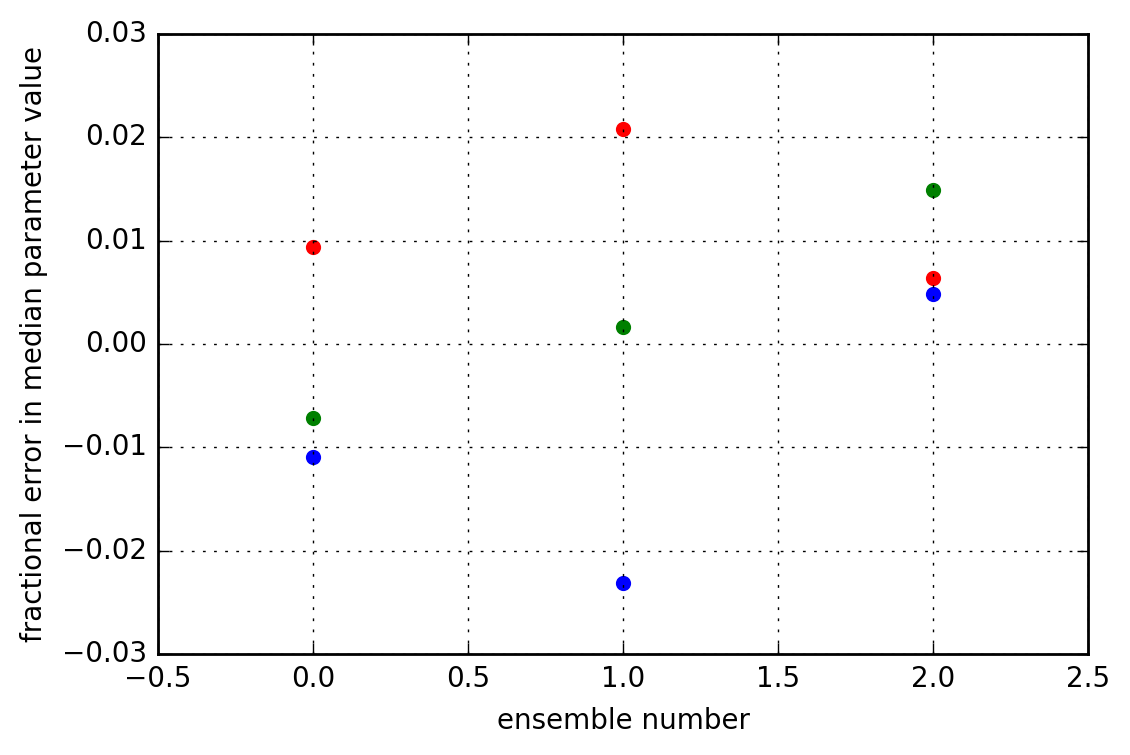

In [662]:
# Show convergence of parameters for successive steps in epsilon
plt.figure()
for jEnsemble in range(nEnsembles):
    plt.scatter( jEnsemble, (np.median(alphaAll[jEnsemble])-alphaML)/alphaML ,color='blue')
    plt.scatter( jEnsemble, (np.median(betaAll[jEnsemble])-betaML)/betaML ,color='red')
    plt.scatter( jEnsemble, (np.median(GammaAll[jEnsemble])-GammaML)/GammaML ,color='green')
    #plt.scatter( epsilonR[jEnsemble], (np.median(alphaAll[jEnsemble])-alphaML)/alphaML ,color='blue')
    #plt.scatter( epsilonP[jEnsemble], (np.median(betaAll[jEnsemble])-betaML)/betaML ,color='red')
    #plt.scatter( epsilonGamma[jEnsemble], (np.median(GammaAll[jEnsemble])-GammaML)/GammaML ,color='green')
    print((np.median(alphaAll[jEnsemble])-alphaML)/alphaML)
    print((np.median(betaAll[jEnsemble])-betaML)/betaML)
    print((np.median(GammaAll[jEnsemble])-GammaML)/GammaML)
#plt.xlabel('ensemble number')
plt.xlabel('ensemble number')
plt.ylabel('fractional error in median parameter value')
plt.grid()


In [671]:
pObserved.reshape(-1,1)

array([[ 293.70829153],
       [ 106.38241937],
       [  71.53664085],
       [  52.3492338 ],
       [  66.16225665],
       [  59.13542351],
       [ 111.69561238],
       [  80.80441273],
       [  56.40142013],
       [ 106.65006874],
       [  50.71044339],
       [  52.47638377],
       [  63.75192327],
       [  55.53792018],
       [ 103.30635095],
       [  57.65202944],
       [ 132.26474832],
       [ 255.60288039],
       [ 127.73956367],
       [ 100.61747954],
       [  56.21753972],
       [ 100.38792429],
       [  53.29121643],
       [  69.31927645],
       [  50.77803706],
       [ 158.10865105],
       [  91.54737174],
       [  81.95855851],
       [  62.35858612],
       [ 101.48959319],
       [  92.43074531],
       [  58.70037786],
       [ 199.0755757 ],
       [  52.66592927],
       [ 103.58263557],
       [  98.30924406],
       [  80.42231523],
       [ 177.04144106],
       [ 104.62484107],
       [  78.63371358],
       [  75.50952951],
       [ 210.244

Sum of KDE probs for P observed 1.0
Sum of KDE probs for R observed 1.0
Sum of KDE probs for P Simulated 1.0
Sum of KDE probs for R Simulated 1.0
Hellinger Distances (R and P): Histogram -- [0.16253917830530207, 0.16684197442081589]
Hellinger Distances (R and P): KDE -- [0.071547471179020009, 0.041286947935764734]
KDE bandwidths: rSim, rObs, pSim, pObs [0.18358704564963091, 0.18651187726650878, 24.486252517746255, 28.442343161393335]


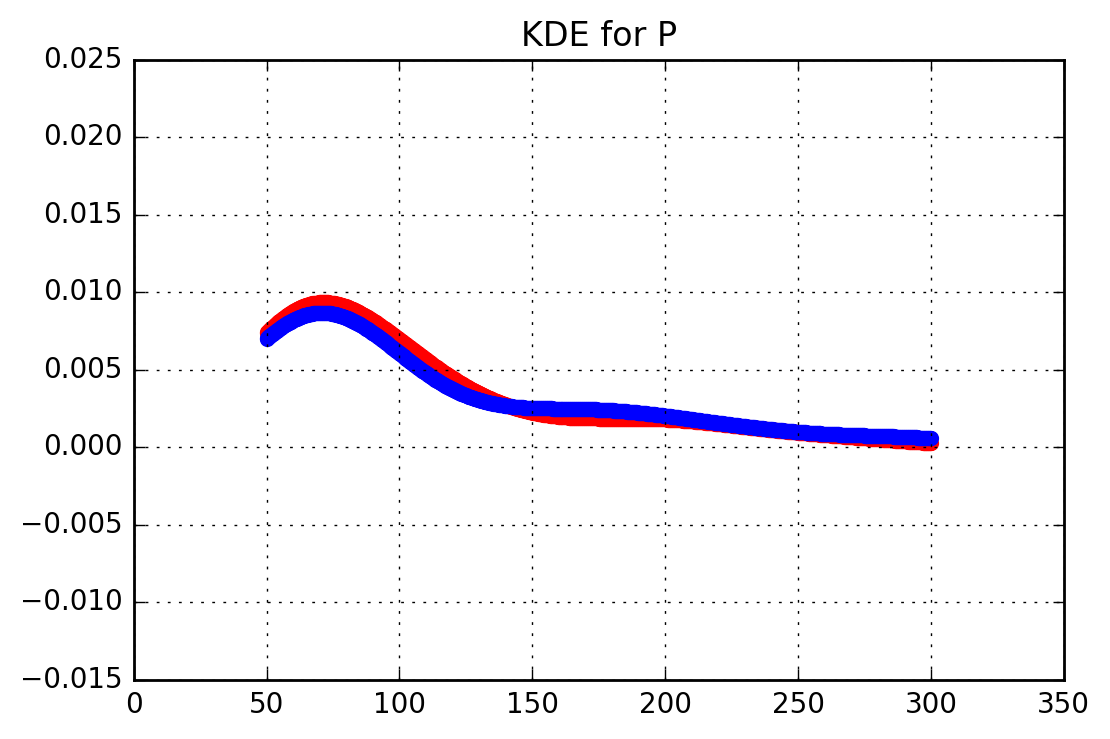

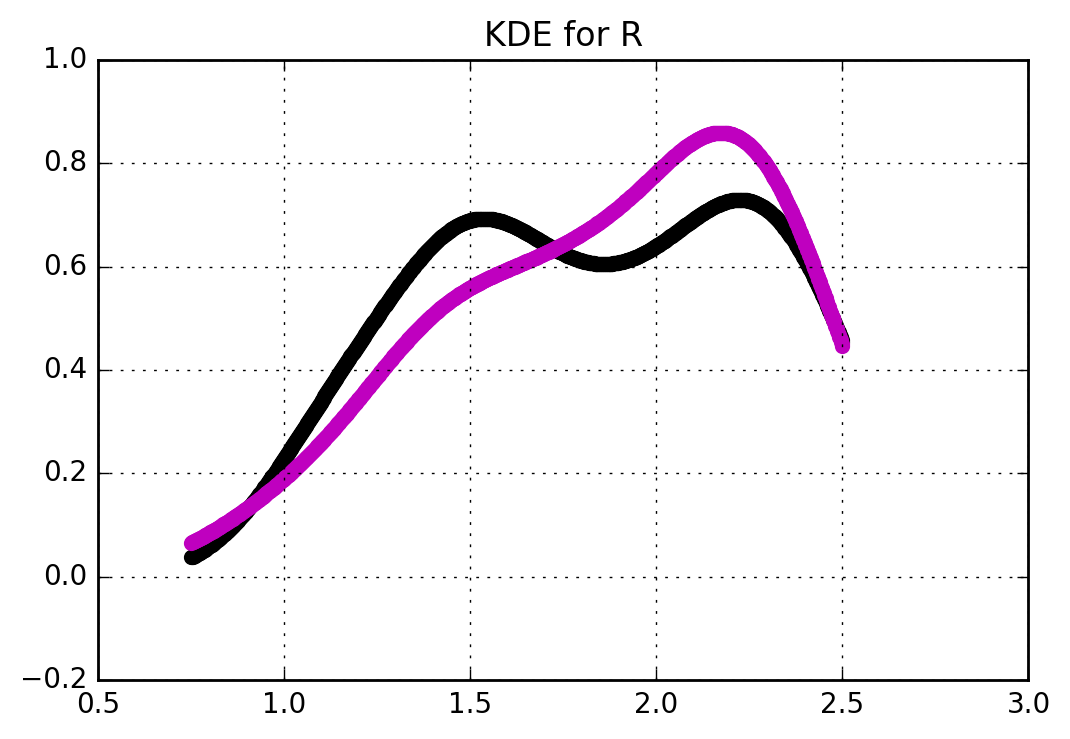

In [825]:
# !!!!! Testing KDE from sklearn

from sklearn.neighbors import KernelDensity

bw_rObserved =np.std(rObserved)*( 4./3./float(len(rObserved))) **(1./5.); 
bw_rSimulated =np.std(rSimulated)*( 4./3./float(len(rSimulated))) **(1./5.); 
bw_pObserved =np.std(pObserved)*( 4./3./float(len(pObserved))) **(1./5.); 
bw_pSimulated =np.std(pSimulated)*( 4./3./float(len(pSimulated))) **(1./5.); 

nBins = 50

pObserved = observedCatalog[0]
rObserved = observedCatalog[1]
pSimulated = simulatedCatalog[0]
rSimulated = simulatedCatalog[1]
# Number of objects contained in each catalog
nSimulated = len(simulatedCatalog[0])
nObserved = len(observedCatalog[0])

    
P_plot= np.linspace(pMin,pMax,1000).reshape(-1,1)
dP = P_plot[1] - P_plot[0]

R_plot= np.linspace(rMin,rMax,1000).reshape(-1,1)
dR = R_plot[1] - R_plot[0]

        
kde_pObserved = KernelDensity(kernel='gaussian', bandwidth=bw_pObserved).fit(pObserved.reshape(-1,1))
log_dens_pObserved = kde_pObserved.score_samples(P_plot)
prob_pObserved = np.exp(log_dens_pObserved)

kde_pSimulated = KernelDensity(kernel='gaussian', bandwidth=bw_pSimulated).fit(pSimulated.reshape(-1,1))
log_dens_pSimulated = kde_pSimulated.score_samples(P_plot)
prob_pSimulated = np.exp(log_dens_pSimulated)

kde_rObserved = KernelDensity(kernel='gaussian', bandwidth=bw_rObserved).fit(rObserved.reshape(-1,1))
log_dens_rObserved = kde_rObserved.score_samples(R_plot)
prob_rObserved = np.exp(log_dens_rObserved)

kde_rSimulated = KernelDensity(kernel='gaussian', bandwidth=bw_rSimulated).fit(rSimulated.reshape(-1,1))
log_dens_rSimulated = kde_rSimulated.score_samples(R_plot)
prob_rSimulated = np.exp(log_dens_rSimulated)
            
# Probability distributions of period and radius in observed catalog
probPobserved, pBinsObserved = np.histogram(pObserved, bins = np.linspace(pMin,pMax,nBins), density = True)
probRobserved, rBinsObserved = np.histogram(rObserved, bins = np.linspace(rMin,rMax,nBins), density = True)
    
# Probability distributions of period and radius in observed catalog
probPsimulated, pBinsSimulated = np.histogram(pSimulated, bins = np.linspace(pMin,pMax,nBins), density = True)
probRsimulated, rBinsSimulated = np.histogram(rSimulated, bins = np.linspace(rMin,rMax,nBins), density = True)

# Bin spacing in R and P
dP = pBinsObserved[1] - pBinsObserved[0]
dR = rBinsObserved[1] - rBinsObserved[0]
                
# Squared Hellinger distances for R and P histogram discrete PDFs
rDistanceHistogram = 0.5*np.sum( ( np.sqrt(probRsimulated*dR) - np.sqrt(probRobserved*dR) )**2 )
pDistanceHistogram = 0.5*np.sum( ( np.sqrt(probPsimulated*dP) - np.sqrt(probPobserved*dP) )**2 ) 

# Squared Hellinger distances for KDE discrete PDFs
rDistanceKDE = 0.5*np.sum( ( np.sqrt(prob_rSimulated*dR) - np.sqrt(prob_rObserved*dR) )**2 )
pDistanceKDE = 0.5*np.sum( ( np.sqrt(prob_pSimulated*dP) - np.sqrt(prob_pObserved*dP) )**2 ) 
    
# Distance is absolute fractional difference
nDistance = np.abs((float(nSimulated - nObserved))/float(nObserved))


# Results
print('Sum of KDE probs for P observed ' +str(sum(probPobserved*dP)))
print('Sum of KDE probs for R observed ' +str(sum(probRobserved*dR)))
print('Sum of KDE probs for P Simulated ' +str(sum(probPsimulated*dP)))
print('Sum of KDE probs for R Simulated ' +str(sum(probRsimulated*dR)))
print('Hellinger Distances (R and P): Histogram -- '+ str([rDistanceHistogram, pDistanceHistogram]))
print('Hellinger Distances (R and P): KDE -- '+ str([rDistanceKDE, pDistanceKDE]))
print('KDE bandwidths: rSim, rObs, pSim, pObs ' + str([bw_rSimulated, bw_rObserved, bw_pSimulated, bw_pObserved]))
plt.figure()
plt.grid()
plt.scatter(P_plot,prob_pSimulated, color='red')
plt.scatter(P_plot,prob_pObserved, color='blue')
plt.title('KDE for P')

plt.figure()
plt.grid()
plt.scatter(R_plot,prob_rSimulated,color='k')
plt.scatter(R_plot,prob_rObserved,color='m')
plt.title('KDE for R')


/Users/jcatanza/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jcatanza/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jcatanza/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:91: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jcatanza/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:92: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


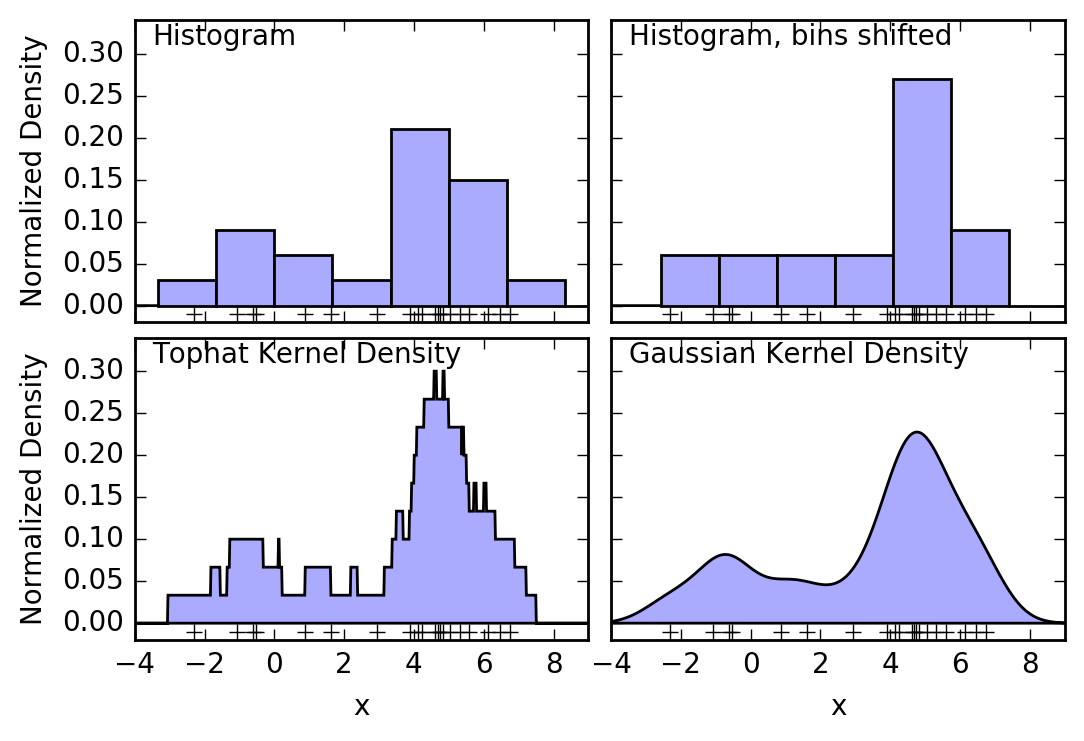

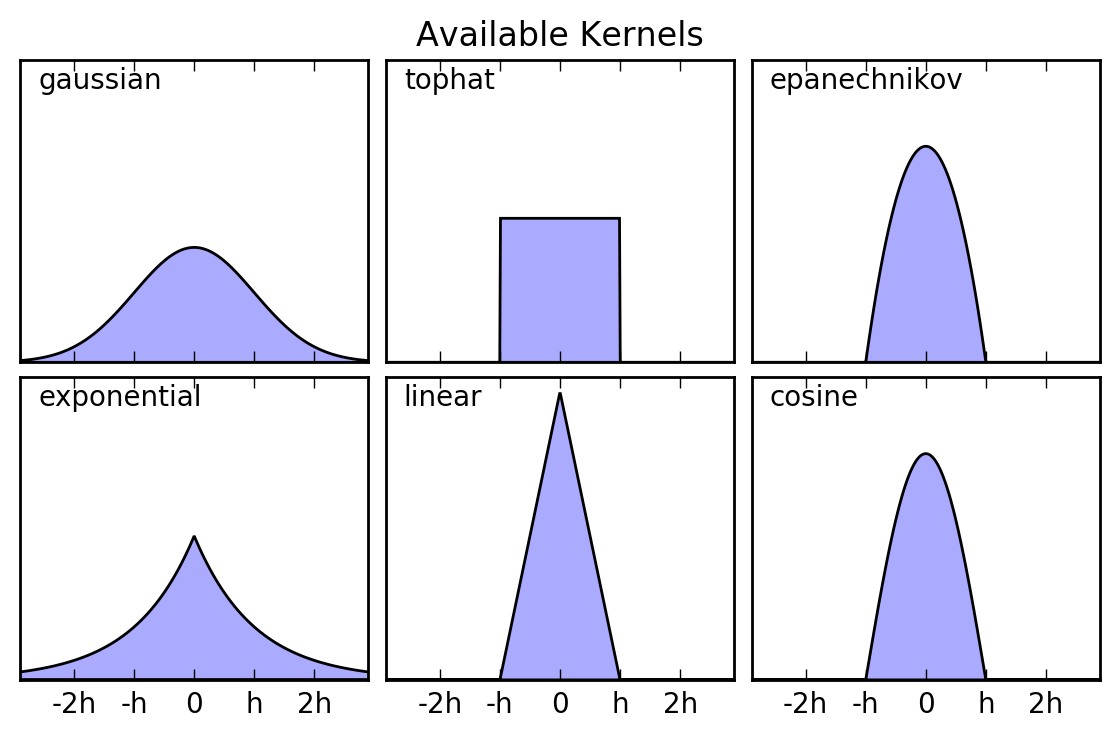

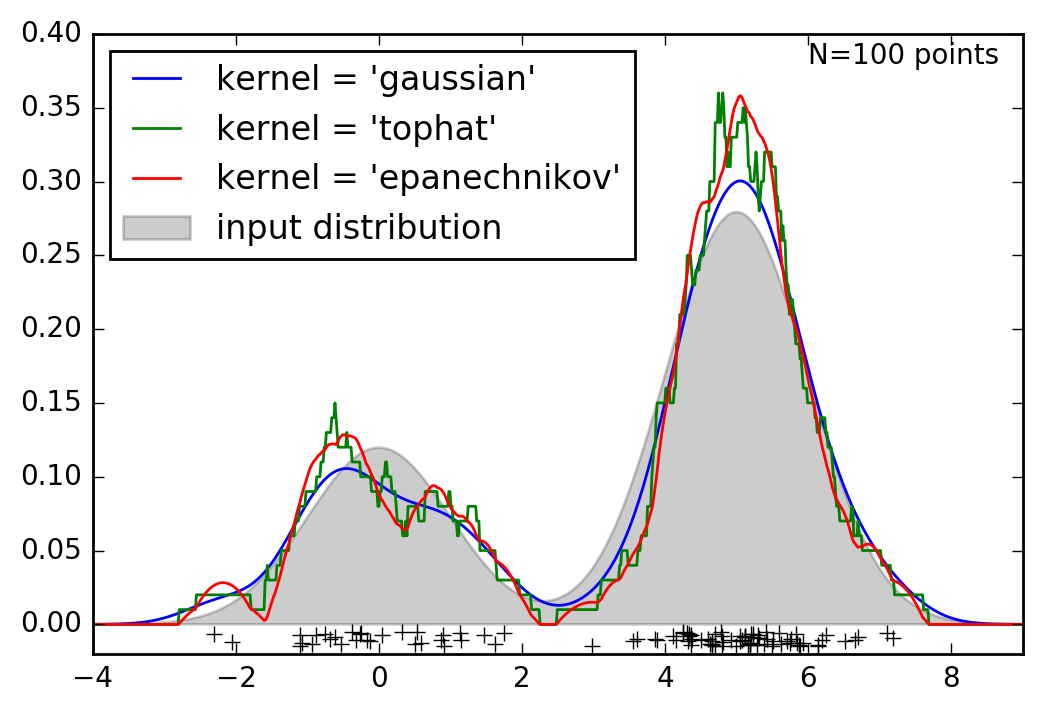

In [676]:
# Author: Jake Vanderplas <jakevdp@cs.washington.edu>
#
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.neighbors import KernelDensity


#----------------------------------------------------------------------
# Plot the progression of histograms to kernels
np.random.seed(1)
N = 20
X = np.concatenate((np.random.normal(0, 1, 0.3 * N),
                    np.random.normal(5, 1, 0.7 * N)))[:, np.newaxis]
X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]
bins = np.linspace(-5, 10, 10)

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.05, wspace=0.05)

# histogram 1
ax[0, 0].hist(X[:, 0], bins=bins, fc='#AAAAFF', normed=True)
ax[0, 0].text(-3.5, 0.31, "Histogram")

# histogram 2
ax[0, 1].hist(X[:, 0], bins=bins + 0.75, fc='#AAAAFF', normed=True)
ax[0, 1].text(-3.5, 0.31, "Histogram, bins shifted")

# tophat KDE
kde = KernelDensity(kernel='tophat', bandwidth=0.75).fit(X)
log_dens = kde.score_samples(X_plot)
ax[1, 0].fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
ax[1, 0].text(-3.5, 0.31, "Tophat Kernel Density")

# Gaussian KDE
kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(X)
log_dens = kde.score_samples(X_plot)
ax[1, 1].fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
ax[1, 1].text(-3.5, 0.31, "Gaussian Kernel Density")

for axi in ax.ravel():
    axi.plot(X[:, 0], np.zeros(X.shape[0]) - 0.01, '+k')
    axi.set_xlim(-4, 9)
    axi.set_ylim(-0.02, 0.34)

for axi in ax[:, 0]:
    axi.set_ylabel('Normalized Density')

for axi in ax[1, :]:
    axi.set_xlabel('x')

#----------------------------------------------------------------------
# Plot all available kernels
X_plot = np.linspace(-6, 6, 1000)[:, None]
X_src = np.zeros((1, 1))

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True)
fig.subplots_adjust(left=0.05, right=0.95, hspace=0.05, wspace=0.05)


def format_func(x, loc):
    if x == 0:
        return '0'
    elif x == 1:
        return 'h'
    elif x == -1:
        return '-h'
    else:
        return '%ih' % x

for i, kernel in enumerate(['gaussian', 'tophat', 'epanechnikov',
                            'exponential', 'linear', 'cosine']):
    axi = ax.ravel()[i]
    log_dens = KernelDensity(kernel=kernel).fit(X_src).score_samples(X_plot)
    axi.fill(X_plot[:, 0], np.exp(log_dens), '-k', fc='#AAAAFF')
    axi.text(-2.6, 0.95, kernel)

    axi.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
    axi.xaxis.set_major_locator(plt.MultipleLocator(1))
    axi.yaxis.set_major_locator(plt.NullLocator())

    axi.set_ylim(0, 1.05)
    axi.set_xlim(-2.9, 2.9)

ax[0, 1].set_title('Available Kernels')

#----------------------------------------------------------------------
# Plot a 1D density example
N = 100
np.random.seed(1)
X = np.concatenate((np.random.normal(0, 1, 0.3 * N),
                    np.random.normal(5, 1, 0.7 * N)))[:, np.newaxis]

X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]

true_dens = (0.3 * norm(0, 1).pdf(X_plot[:, 0])
             + 0.7 * norm(5, 1).pdf(X_plot[:, 0]))

fig, ax = plt.subplots()
ax.fill(X_plot[:, 0], true_dens, fc='black', alpha=0.2,
        label='input distribution')

for kernel in ['gaussian', 'tophat', 'epanechnikov']:
    kde = KernelDensity(kernel=kernel, bandwidth=0.5).fit(X)
    log_dens = kde.score_samples(X_plot)
    ax.plot(X_plot[:, 0], np.exp(log_dens), '-',
            label="kernel = '{0}'".format(kernel))

ax.text(6, 0.38, "N={0} points".format(N))

ax.legend(loc='upper left')
ax.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), '+k')

ax.set_xlim(-4, 9)
ax.set_ylim(-0.02, 0.4)
plt.show()


In [680]:
sum(np.exp(log_dens)*(X_plot[1]-X_plot[0]))


0.99999853581994846

In [793]:
    """
    Returns either Hellinger distances between histograms,
    or L2 distances between empirical CDFs for R and P catalogs,
    and the fractional distance between catalogs for Gamma
    
    Catalogs are assumed to be lists of [R,P]
    
    """
    
    # Extract period and radius from catalogs
    pObserved = observedCatalog[0]
    rObserved = observedCatalog[1]
    pSimulated = simulatedCatalog[0]
    rSimulated = simulatedCatalog[1]
    # print([len(rObserved),len(rSimulated)])
    
    # Number of objects contained in each catalog
    nSimulated = len(simulatedCatalog[0])
    nObserved = len(observedCatalog[0])
    
    distanceMetric = 'H'
    useKDE = True
    
    # bandWidth = 0.75 
    bandWidthR = .1 
    bandWidthP = 5
    # Silverman's rule n = number of points, d = number of dimensions
    # Note silverman's rule gives a multiplier for the std
    bw = (n * (d + 2) / 4.)**(-1. / (d + 4))
    bw = (n * 3 / 4.)**(-1. / 5)
    bwObserved = (nObserved * 3 / 4.)**(-1. / 5)
    bwSimulated = (nSimulated * 3 / 4.)**(-1. / 5)
    
    # Note KDE from scipy
    # from scipy import stats   
    # scipy.stats.gaussian_kde(dataset, bw_method=None) 
    # bw_method can be 'silverman' or 'scott' (default)
    # Scott’s Rule, implemented as scotts_factor, is:
    # n**(-1./(d+4)), with n the number of data points and d the number of dimensions. 
    # Silverman’s Rule, implemented as silverman_factor, is:
    # (n * (d + 2) / 4.)**(-1. / (d + 4)).


    # Specify distance metric -- H for Hellinger, K for Kolmogorov
    if(distanceMetric == 'H'):
    
        # !!!!! Hellinger distance -- applicable to PDFs.
        # !!!!! Jessi, Eric, and Tom suggested to do kernel density estimation to get the PDF
        # Here, PDFs of R and P are estimated by histograms
    
        if(not useKDE):
        
            # Probability distributions of period and radius in observed catalog
            probPobserved, pBinsObserved = np.histogram(pObserved, bins = np.linspace(pMin,pMax,nBins), density = True)
            probRobserved, rBinsObserved = np.histogram(rObserved, bins = np.linspace(rMin,rMax,nBins), density = True)
    
            # Probability distributions of period and radius in observed catalog
            probPsimulated, pBinsSimulated = np.histogram(pSimulated, bins = np.linspace(pMin,pMax,nBins), density = True)
            probRsimulated, rBinsSimulated = np.histogram(rSimulated, bins = np.linspace(rMin,rMax,nBins), density = True)

            # Bin spacing in R and P
            dP = pBinsObserved[1] - pBinsObserved[0]
            dR = rBinsObserved[1] - rBinsObserved[0]
        
    
            # print(sum(probPobserved*dP))
            # print(sum(probRobserved*dR))
        
            # Squared Hellinger distances for R and P discrete PDFs
            # distance scale should be indep of number of bins
            rDistance = 0.5*np.sum( ( np.sqrt(probRsimulated*dR) - np.sqrt(probRobserved*dR) )**2 )
            pDistance = 0.5*np.sum( ( np.sqrt(probPsimulated*dP) - np.sqrt(probPobserved*dP) )**2 ) 
    
            # Handle cases of nans. Note sure why this happens?
            if(np.isnan(rDistance)):   
                rDistance = 100000
            if(np.isnan(pDistance)):   
                pDistance = 100000
                
        else:
            
            # Use KDE to compute Hellinger distances
            nGrid = 1000
            
            P_plot= np.linspace(pMin,pMax,nGrid).reshape(-1,1)
            dP = P_plot[1] - P_plot[0]
            
            R_plot= np.linspace(rMin,rMax,nGrid).reshape(-1,1)
            dR = R_plot[1] - R_plot[0]

            kde_pObserved = KernelDensity(kernel='gaussian', bandwidth=bandWidthP).fit(pObserved.reshape(-1,1))
            log_dens_pObserved = kde_pObserved.score_samples(P_plot)
            prob_pObserved = np.exp(log_dens_pObserved)

            kde_pSimulated = KernelDensity(kernel='gaussian', bandwidth=bandWidthP).fit(pSimulated.reshape(-1,1))
            log_dens_pSimulated = kde_pSimulated.score_samples(P_plot)
            prob_pSimulated = np.exp(log_dens_pSimulated)

            kde_rObserved = KernelDensity(kernel='gaussian', bandwidth=bandWidthR).fit(rObserved.reshape(-1,1))
            log_dens_rObserved = kde_rObserved.score_samples(R_plot)
            prob_rObserved = np.exp(log_dens_rObserved)

            kde_rSimulated = KernelDensity(kernel='gaussian', bandwidth=bandWidthR).fit(rSimulated.reshape(-1,1))
            log_dens_rSimulated = kde_rSimulated.score_samples(R_plot)
            prob_rSimulated = np.exp(log_dens_rSimulated)
            
        # KDE distances
        rDistance = 0.5*np.sum( ( np.sqrt(prob_rSimulated*dR) - np.sqrt(prob_rObserved*dR) )**2 )
        pDistance = 0.5*np.sum( ( np.sqrt(prob_pSimulated*dP) - np.sqrt(prob_pObserved*dP) )**2 ) 
        

sum(prob_rSimulated*dR)

KDE bandwidths [0.18358704564963091, 0.18651187726650878, 24.486252517746255, 28.442343161393335]
Hellinger distances [0.0077583599261674321, 0.044302323783053738]


17.0068487964


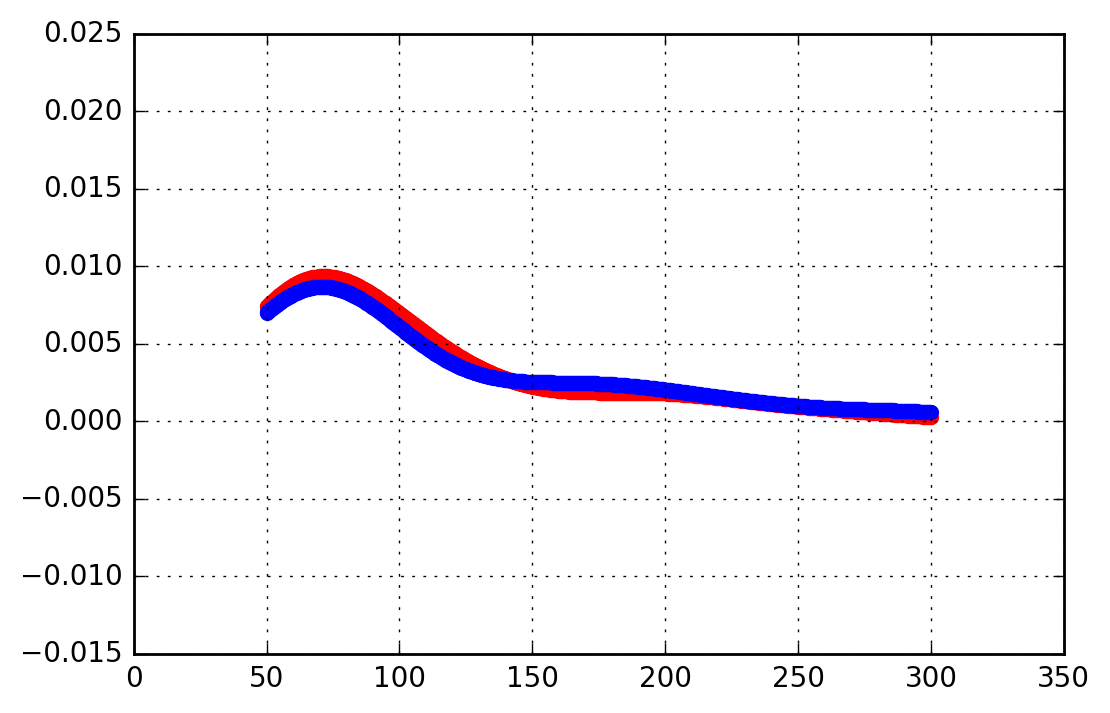

In [813]:


print(sum(prob_pSimulated*dP))
#import scipy
#a=np.array([1,1,1,1,1])
#scipy.integrate.simps(a,np.array([0,10,20,30,40]))

# print(np.trapz(prob_pSimulated,P_plot) )
#nBins
#P_plotT = P_plot.T
#P_plot.shape
#prob_pSimulated.shape

#I = scipy.integrate.simps(prob_pSimulated,np.linspace(pMin,pMax,nGrid))
#print(I)
#type(prob_pSimulated)
#type(P_plot)

0.58163959181026326

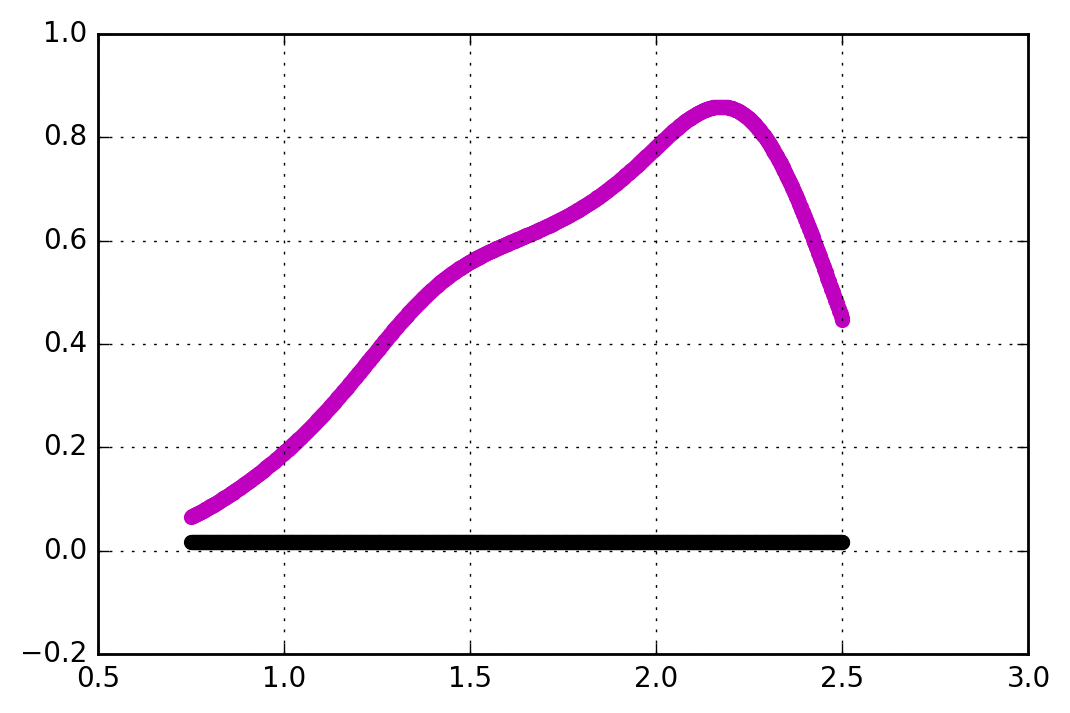

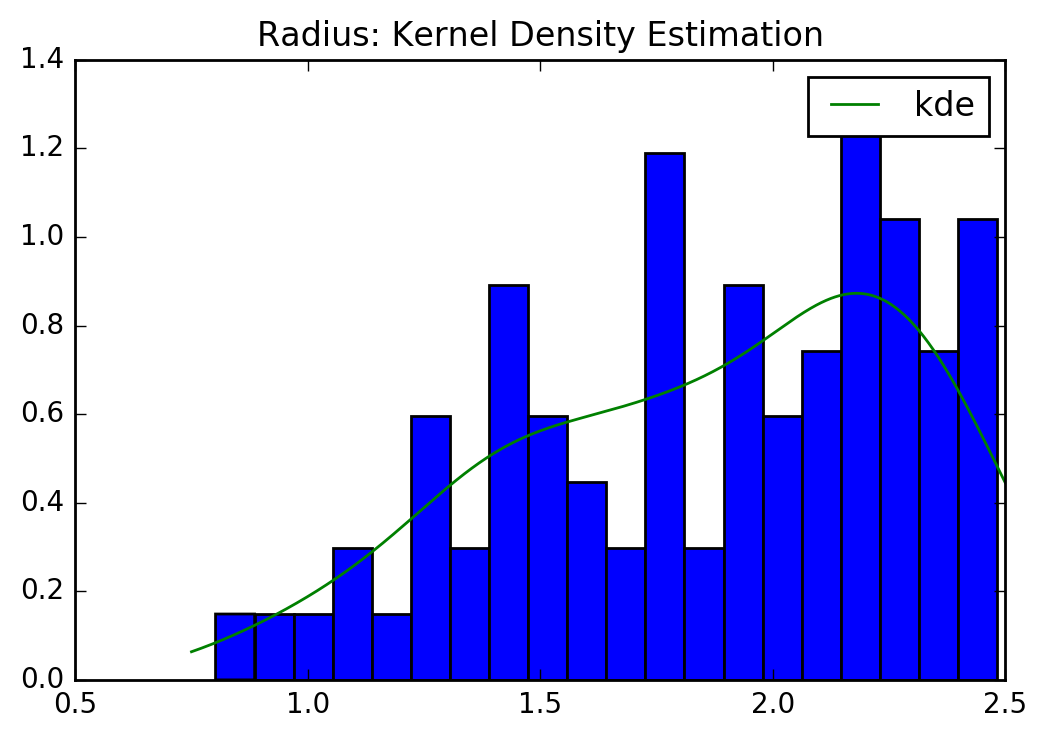

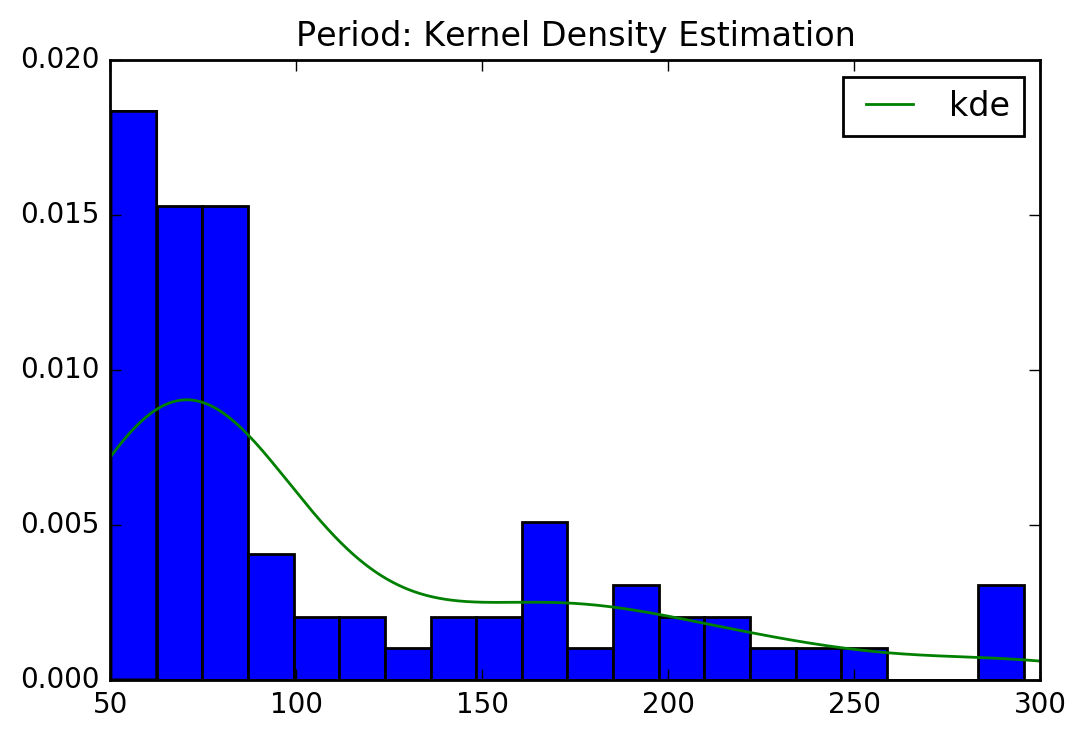

In [805]:
# Playing with scipy.stats.
# From http://jpktd.blogspot.com/2009_03_01_archive.html
import numpy as np
from scipy import stats
import matplotlib.pylab as plt

# kde_rObserved = KernelDensity(kernel='gaussian', bandwidth=bandWidthR).fit(rObserved.reshape(-1,1))
# log_dens_rObserved = kde_rObserved.score_samples(R_plot)
# prob_rObserved = np.exp(log_dens_rObserved)
# Normalize PDF
# norm = scipy.integrate.simps(prob_rObserved,np.linspace(rMin,rMax,nGrid))
# prob_rObserved = prob_rObserved/norm
# I = scipy.integrate.simps(prob_rObserved,np.linspace(rMin,rMax,nGrid))
# print(I)


# ========================
n_basesample = len(rObserved)
xn = rObserved

# Now, we create an instance of the gaussian_kde class and feed our sample to it:
gkde=stats.gaussian_kde(xn)

# Evaluate the density funtion
ind = np.linspace(rMin,rMax,nGrid)
kdepdf = gkde.evaluate(ind)

# plot the histogram of the data, together with the density that created our sample, 
# and the estimated density.
plt.figure()

# plot histogram of sample
plt.hist(xn, bins=20, normed=1)

# plot estimated density
plt.plot(ind, kdepdf, label='kde', color="g")
plt.title('Radius: Kernel Density Estimation')
plt.legend()
#plt.show()

#===============
# Period
n_basesample = len(pObserved)
xn = pObserved

# Now, we create an instance of the gaussian_kde class and feed our sample to it:
gkde=stats.gaussian_kde(xn)

# Evaluate the density funtion
ind = np.linspace(pMin,pMax,nGrid)
kdepdf = gkde.evaluate(ind)

# plot the histogram of the data, together with the density that created our sample, 
# the data generating process DGP, and finally the estimated density.
plt.figure()

# plot histgram of sample
plt.hist(xn, bins=20, normed=1)

# plot estimated density
plt.plot(ind, kdepdf, label='kde', color="g")
plt.title('Period: Kernel Density Estimation')
plt.legend()
#plt.show()



In [800]:
nObserved**(-1/5)

0.41627660370093655

In [801]:
nSimulated**(-1/5)

0.4005397783429008